The goal of this notebook is to disambiguate WordNet nominal event synsets associated to multiple VerbAtlas frames. A neural network was trained to classify unambiguous synset definitions for the purpose of classifying ambiguous ones.

#Imports and Constants

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install transformers
!git clone "https://github.com/Omar659/verbatlas.git"

In [ ]:
import numpy as np
import random
import json
import csv
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from collections import Counter

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from scipy.ndimage import gaussian_filter
# Transformers
from transformers import AutoTokenizer
from transformers import AutoModel

# For iteration bars
from tqdm.auto import tqdm

# Nltk wordnet
from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

In [ ]:
class VerbAtlas():
    def __init__(self, folder_path):
        # VA_bn2va.tsv: lists the BabelNet synsets in each VerbAtlas frame
        self.bn2va = self.__read_tsv(folder_path + "/VerbAtlas-1.1.0/VA_bn2va.tsv")
        self.bn_va_dict = [{}, defaultdict(lambda : [])]
        for bn2va_i in self.bn2va:
            self.bn_va_dict[0][bn2va_i[0]] = bn2va_i[1]
            self.bn_va_dict[1][bn2va_i[1]].append(bn2va_i[0])
            
        # bn2wn.tsv: mapping from BabelNet to WordNet
        self.bn2wn = self.__read_tsv(folder_path + "/VerbAtlas-1.1.0/bn2wn.tsv")
        self.bn_wn_dict = {}
        for bn2wn_i in self.bn2wn:
            self.bn_wn_dict[bn2wn_i[0]] = [bn2wn_i[1][3:-1], bn2wn_i[1][-1]]

        # VA_frame_info.tsv: mapping from VerbAtlas ID to all the frame information, 
        # including the frame name (second field)
        self.frame_info = self.__read_tsv(folder_path + "/VerbAtlas-1.1.0/VA_frame_info.tsv")
        self.frame_info_dict = {}
        for frame_info_i in self.frame_info:
            self.frame_info_dict[frame_info_i[0]] = frame_info_i[1:]

        # README of VerbAtlas
        with open(folder_path + "README.md") as file:
            my_file = csv.reader(file, delimiter="\t")
            readme = "\n".join([line[0] for line in my_file if line != []])
            print(readme)

    def __read_tsv(self, path):
        # Read a file from VerbAtlas
        tsv_file = []
        with open(path) as file:
            my_file = csv.reader(file, delimiter="\t")
            for line in list(my_file)[1:]:
                tsv_file.append(line)
        return tsv_file

# Verbatlas frames
vf = VerbAtlas("./verbatlas/")

In [ ]:
# Set the seed for the randoms
def set_random_seed():
    SEED = 104
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
set_random_seed()

# Path
# path to folder that contains files
ROOT_PATH = "./drive/MyDrive/EAI/NLP/HW2/Project_NUANS/"
# ROOT_PATH = "./drive/MyDrive/Project_NUANS/"
CHECKPOINTS_PATH = ROOT_PATH + "Model_ckp/"
DATASETS_PATH = ROOT_PATH + "Datasets/"
OUTPUT_PATH = ROOT_PATH + "Outputs/"

# Patience
LEN_STACK_PATIENCE = 4
PATIENCE = 5
# Optim
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.0
TRANSFORMER_LEARNING_RATE = 5e-5
TRANSFORMER_WEIGHT_DECAY = 0.0
# Training
BATCH_SIZE = 16
EPOCHS = 100
# Architecture
HIDDEN_DIM_LSTM = 200
POS_EMBEDDING_DIM = 128
VERB_FRAME_DIM = 128
BIDIRECTIONAL = True
NUM_LAYER_LSTM = 2
DROPOUT = 0.2
DROPOUT_LSTM = 0.3

# Other
TRANFORMER_CHECKPOINT = "bert-base-uncased"
TOKENIZER = AutoTokenizer.from_pretrained(TRANFORMER_CHECKPOINT)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)

POS = ["<PAD>", "ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", 
       "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]
with open(DATASETS_PATH + "labels_classification.json", "r") as file:
    LABEL = json.load(file)
# these are all the frames associated to synsets that appear less than a certain
# value in the dataset (best result 11)
with open(DATASETS_PATH + "other_labels_classification.json", "r") as file:
    LABEL_OTHER = json.load(file)
VERB_FRAME = ["~"] + [label[1] for label in vf.frame_info]

def encode(list_to_encode):
    id2code= {}
    code2id = {}
    for id, code in enumerate(list_to_encode):
        id2code[id] = code
        code2id[code] = id
    return id2code, code2id

ID_TO_LABEL, LABEL_TO_ID = encode(LABEL)
ID_TO_LABEL_OTHER, LABEL_OTHER_TO_ID = encode(LABEL_OTHER)
ID_TO_VERB_FRAME, VERB_FRAME_TO_ID = encode(VERB_FRAME)
ID_TO_POS, POS_TO_ID = encode(POS)

# Functions and classes

In [ ]:
def pprint(obj):
    '''
        Indented print of an object
    '''
    print(json.dumps(obj, indent=3))

def data_loading(dataset, shuffle):
    """
    Function used to create a dataloader and print some usefull information.
    Args:
        dataset: dataset on which you want to build the dataloader
        shuffle: whether or not I should shuffle the dataloader obtained 
    Return:
        data_loader: the DataLoader object
    """
    data_loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = shuffle)
    print(dataset)
    print("batch size: " + str(BATCH_SIZE))
    print("number of batches: " + str(len(data_loader)))
    return data_loader

In [ ]:
class MyDataset(Dataset):
    def __init__(self, mode):
        """
        Args:
            mode: "train": if I want use the training set 
                  "dev":   if I want use the development set
                  "test":  if I want use the test set
                  "final": if I want use the final set for the disambiguation task
        """
        self.mode = mode
        self.transformer_name = TRANFORMER_CHECKPOINT
        self.dataset = self.read_dataset()
        self.sentences, self.labels, self.pos, self.verb_frame, self.synsets = self.sentence_from_data()
        self.encoded_data = self.encode()
    
    def read_dataset(self):
        '''
        Function used to read the datasets
        Return:
            sets: datasets loaded
        '''
        with open(DATASETS_PATH + "dataset_classification.json", "r") as f:
            sets = json.load(f)
        return sets

    def compute_frequences(self):
        '''
        These function compute the frequencies of the VerbAtlas frame associated
        to the synsets in the dataset, then a weight is applied to each 
        verbatlas frame in this way the rarest are not penalized.
        Return:
            - tensor with the weights for each VerbAtlas frame
        '''
        label_freq = {}
        for label in LABEL:
            label_freq[label] = 0
        for value in self.dataset["train"].values():
            label_freq[value[1]] += 1
        freqs = list(label_freq.items())

        freqs = np.array([x[1] for x in freqs])
        freqs = np.exp(-np.array(freqs)) + 1e-30
        freqs /= np.sum(freqs)
        freqs = np.log(freqs)
        
        freqs = (freqs - min(freqs)) + 1
        return torch.Tensor(freqs).to(DEVICE)
        # other tests with different weighting function (gaussian)
        # gaussian_distribution = gaussian_filter(freqs, 5)
        # w = lambda p_tilde,l: 1/((1-l)*p_tilde + l/len(LABEL))
        # weighting_factor = w(gaussian_distribution, 0.5)
        # weighting_factor = weighting_factor/np.dot(gaussian_distribution, weighting_factor)
        # return torch.Tensor(weighting_factor).to(DEVICE)

    def sentence_from_data(self):
        """
        Method used to extract the necessary information from the dataset 
        and apply initial preprocessing.
        Return:
            sentences:  list of words of the synset definition. 
            labels:     list of labels.
            pos:        list of part of speech tags for each word.
            verb_frame: list of VerbAtlas frame for each verb of the sentence, "~" for other words
            synsets:    list of names of synsets.
        """
        sentences = []
        labels = []
        pos = []
        verb_frame = []
        synsets = []
        for synset, synset_info in self.dataset[self.mode].items():
            sentences.append([item[0] for item in synset_info[0]])
            pos.append([item[1] for item in synset_info[0]])
            verb_frame.append([item[2] for item in synset_info[0]])
            labels.append(synset_info[1])
            synsets.append(synset)
        return sentences, labels, pos, verb_frame, synsets

    def encode(self):
        """
        Method used to convert the preprocess performed by "sentence_from_data()" 
        to an encoding that the model can read.
        Return:
            encoded: list of the input of the model:
                     {
                        transformer_inputs: tokenized sentence,
                        labels: for each sentence a label is event or not event;
                        pos_idx: list of indices that identify which pos has a word, 
                                0 is the pad token
                        verb_frame_idx: list of indices that identify which 
                                verbatlas frame has a word, 0 is the index of "~" 
                     }
        """
        tokenized = TOKENIZER(
            self.sentences, 
            return_tensors = "pt", 
            truncation = True, 
            padding = True,
            is_split_into_words = True
        )
        tokenized.to(DEVICE)
        encoded = []
        for i in range(len(tokenized["input_ids"])):
            entry = {}
            for key, value in tokenized.items():
                entry[key] = value[i]
            word_ids = tokenized.word_ids(batch_index=i)
            previous_word_idx = None
            pos = []
            verb_frame = []
            end_sentence = False
            for word_idx in word_ids:
                # Special tokens have a word id that is None.
                # pos for those tokens is set to pad
                if word_idx is None:
                    pos.append(POS_TO_ID["<PAD>"])
                    verb_frame.append(VERB_FRAME_TO_ID["~"])
                # For the first token of each word.
                elif word_idx != previous_word_idx:
                    pos.append(POS_TO_ID[self.pos[i][word_idx]])
                    verb_frame.append(VERB_FRAME_TO_ID[self.verb_frame[i][word_idx]])
                # For the other tokens pos is set to pad
                else:
                    pos.append(POS_TO_ID["<PAD>"])
                    verb_frame.append(VERB_FRAME_TO_ID["~"])
                previous_word_idx = word_idx
            input = {"transformer_inputs": entry,
                     "pos_idx": torch.LongTensor(pos).to(DEVICE),
                     "verb_frame_idx": torch.LongTensor(verb_frame).to(DEVICE)}
            # in "final" set there are no labels
            if self.mode != "final":
                lab = self.labels[i]
                if lab in LABEL_OTHER:
                    lab = "other"
                input["labels"] =  torch.LongTensor([LABEL_TO_ID[lab]]).to(DEVICE)[0]
            encoded.append(input)
        return encoded

    def __len__(self):
        '''
        Return:
            - number of element in the dataset
        '''
        return len(self.encoded_data)

    def __getitem__(self, idx):
        '''
        Return:
            - i-th element of the dataset to iterate on it
        '''
        return self.encoded_data[idx]

    def __str__(self):
        out = "set type: " + self.mode + "Set"
        out += "\ntokenizer used: " + TRANFORMER_CHECKPOINT
        out += "\nset length: " + str(len(self))
        return out

In [ ]:
class Attention_LSTM(nn.Module):
    # Attention layer used to weight the outputs of the LSTM
    def __init__(self, hidden_size):
        super(Attention_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, inputs):
        # inputs has shape (batch_size, seq_len, hidden_size * 2)
        # Calculate the attention weights using a linear layer
        attn_weights = self.attention_weights(inputs)
        # Apply a softmax function to get a probability distribution over the sequence
        attn_weights = F.softmax(attn_weights, dim=1)
        # Multiply the weights by the inputs to get a weighted sum
        weighted_inputs = torch.bmm(attn_weights.transpose(1,2), inputs)
        # Return the weighted sum and the attention weights
        return weighted_inputs, attn_weights

class Event_classification(nn.Module):
    def __init__(self, hparams):
        super(Event_classification, self).__init__()

        self.hparams = hparams
        
        # Number of layers of the LSTM
        self.num_layers = hparams["num_layers_LSTM"]

        # Biderectional or unidirectional LSTM
        self.directions_count = 2 if hparams["bidirectional"] else 1

        # Batch size
        self.batch_size = hparams["batch_size"]

        # LSTM hidden dimension
        self.hidden_dim = hparams["hidden_dim_LSTM"]
        
        # Number of classes
        self.num_labels = hparams["num_labels"]

        # pos embedding
        self.pos_embedding = torch.nn.Embedding(hparams["pos_number"], hparams["pos_dim"], padding_idx = 0)

        # VerbAtalas frame embedding
        self.verb_frame_embedding = torch.nn.Embedding(hparams["verb_frame_number"], hparams["verb_frame_dim"], padding_idx = 0)

        # Transformer
        self.transformer_model = AutoModel.from_pretrained(hparams["transformer_name"], output_hidden_states=True)
        transformer_output_dim = self.transformer_model.config.hidden_size + hparams["pos_dim"] + hparams["verb_frame_dim"]
        
        # LSTM
        self.lstm = nn.LSTM(transformer_output_dim,
                            self.hidden_dim,
                            bidirectional = hparams["bidirectional"],
                            num_layers = self.num_layers, 
                            dropout = hparams["dropout_lstm"] if self.num_layers > 1 else 0,
                            batch_first = True)
    
        # If is the LSTM is bidirectional, then the output dimension is duplicated
        lstm_output_dim = self.hidden_dim if hparams["bidirectional"] is False else self.hidden_dim * 2
        # Attention mask
        self.attention = Attention_LSTM(lstm_output_dim).to(DEVICE)
        # Classifier
        self.classifier = nn.Linear(lstm_output_dim, self.num_labels)
        # Dropout
        self.dropout = torch.nn.Dropout(hparams["dropout"])

        self.train()
    
    def forward(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        labels: torch.Tensor = None,
        verb_frame_idx: torch.Tensor = None,
        pos_idx: torch.Tensor = None,
        compute_loss = True
    ) -> torch.Tensor:
        transformer_input = {
          "input_ids": input_ids, 
          "attention_mask": attention_mask
        }
        if token_type_ids != None:
          transformer_input["token_type_ids"] = token_type_ids
        transformers_outputs = self.transformer_model(**transformer_input)
        transformers_outputs_sum = torch.stack(transformers_outputs.hidden_states[-4:], dim=0).sum(dim=0)
        transformers_outputs_sum = self.dropout(transformers_outputs_sum)

        verb_frame_embedding = self.verb_frame_embedding(verb_frame_idx).squeeze(2)
        pos_embedding = self.pos_embedding(pos_idx).squeeze(2)
        tr_out_with_predicate = torch.cat((transformers_outputs_sum, pos_embedding, verb_frame_embedding), dim = -1)

        embeddings = self.dropout(tr_out_with_predicate)
        
        o, (h, c) = self.lstm(embeddings)
        o = self.dropout(o)

        attn_outputs, attn_weights = self.attention(o)
        c = self.classifier(attn_outputs)
        c = c.squeeze(1)
        output = {"classification": c}
        if compute_loss:
          output["loss"] = self.compute_loss(c, labels)
        return output
    
    def compute_loss(
        self, 
        preds: torch.Tensor, 
        labels: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute the loss of the model.
        Args:
            logits (`torch.Tensor`):
                The logits of the model.
            labels (`torch.Tensor`):
                The labels of the model.
        Returns:
            obj:`torch.Tensor`: The loss of the model.
        """
        return F.cross_entropy(
            preds,
            labels, 
            weight=LOSS_WEIGHTS
        )

In [ ]:
class Trainer():
    def __init__(self, model, optimizer, chk_name):
        """
        Args:
            model: model to train
            optimizer: optimizer to use
            chk_name: name of the checkpoint
        """
        self.model = model
        self.optimizer = optimizer
        self.chk_name = chk_name
    
    def save_model(self, model_name):
        '''
        Method used for save the model.
        '''
        torch.save(self.model.state_dict(),
                            os.path.join(CHECKPOINTS_PATH, "name__" + model_name + "___" + self.chk_name))

    def train(self, train_dataset, valid_dataset, epochs = 100):
        """
        Train the model.
        Args:
            train_dataset: a Dataset or DatasetLoader instance containing 
                           the training instances;
            valid_dataset: a Dataset or DatasetLoader instance used to evaluate
                           learning progress;
            epochs: the number of times to iterate over train_dataset.
        Returns:
            train_losses: list of the training losses over the epochs;
            valid_losses; list of the validation losses over the epochs;
            epoch: number of the last epoch (less than epochs if early stopepd).
        """
        # EARLY STOPPING VARIABLES
        # Current patience
        self.patience = 0
        # Temporal window of validation losses
        self.patience_stack = [1000 for _ in range(LEN_STACK_PATIENCE*2)]

        # Number of samples in the training set
        self.n_sample = len(train_dataset)
        # List of training losses
        train_losses = []

        # List of training losses
        valid_losses = []
        # Validation loss
        valid_loss = 1000.0
        best_valid_loss = 1000.0

        # Start!
        for epoch in tqdm(range(epochs), desc = "Epochs", leave = False):
        # Start training
            epoch_loss = 0.0
            self.model.train()

            # for each batch 
            batch_pbar = tqdm(train_dataset, desc = "Training - Batch", leave = False)
            for batch in batch_pbar:
                self.optimizer.zero_grad()

                # prediction
                model_input = {
                    "input_ids": batch["transformer_inputs"]["input_ids"],
                    "attention_mask": batch["transformer_inputs"]["attention_mask"],
                    "token_type_ids": batch["transformer_inputs"]["token_type_ids"],
                    "labels": batch["labels"],
                    "verb_frame_idx": batch["verb_frame_idx"],
                    "pos_idx": batch["pos_idx"]
                }
                output = self.model(**model_input)
                
                # Compute gradient
                sample_loss = output["loss"]
                sample_loss.backward()

                self.optimizer.step()

                epoch_loss += sample_loss.tolist()
                batch_pbar.set_postfix({'validation_loss': valid_loss, 'training_loss': sample_loss.item(), 'patience': self.patience})
        
            # training epoch loss
            avg_epoch_loss = epoch_loss / len(train_dataset)
            train_losses.append(avg_epoch_loss)
            # validation loss
            valid_loss = self.evaluate(valid_dataset)
            valid_losses.append(valid_loss)

            # Save checkpoint if valid_loss is the best one
            if (valid_loss < best_valid_loss):
                best_valid_loss = valid_loss
                self.save_model("Event_classification_model")

            # Patience check
            patience_counter = 0
            # Count how many times the validation loss is greater than 
            # that obtained in the previous LEN_STACK*2 epochs
            for past_val_loss in self.patience_stack:
                if past_val_loss < valid_loss:
                    patience_counter += 1
            # If it is greater than at least LEN_STACK_PATIENCE epochs, 
            # then increase the patience
            if (patience_counter >= LEN_STACK_PATIENCE):
                self.patience += 1
            # Otherwise decrease it
            else:
                self.patience -= 1
                if self.patience < 0:
                    self.patience = 0
            # If the patience has reached its limit... early stopping!
            if (self.patience == PATIENCE):
                print()
                print("Early stopping!!")
                break
            self.patience_stack = self.patience_stack[1:] + [valid_loss]
        return train_losses, valid_losses, epoch

    def evaluate(self, valid_dataset):
        """
        Evaluate the model.
        Args:
            valid_dataset: the dataset to use to evaluate the model.
        Return:
            avg_valid_loss: the average validation loss over valid_dataset.
        """
        valid_loss = 0.0
        # set dropout to 0 and dont compute gradient.
        self.model.eval()
        with torch.no_grad():
            batch_pbar = tqdm(valid_dataset, desc = "Validation - Batch", leave = False)
            for batch in batch_pbar:
                # Make the predictions
                model_input = {
                    "input_ids": batch["transformer_inputs"]["input_ids"],
                    "attention_mask": batch["transformer_inputs"]["attention_mask"],
                    "token_type_ids": batch["transformer_inputs"]["token_type_ids"],
                    "labels": batch["labels"],
                    "verb_frame_idx": batch["verb_frame_idx"],
                    "pos_idx": batch["pos_idx"]
                }
                output = self.model(**model_input)

                # Save the loss
                sample_loss = output["loss"]
                valid_loss += sample_loss.tolist()
                batch_pbar.set_postfix({'validation_loss': sample_loss.item(), 'patience': self.patience})              
        avg_valid_loss = valid_loss / len(valid_dataset)
        return avg_valid_loss
    
    def test(self, test_dataset):
        """
        Test the model.
        Args:
            test_dataset: the dataset to use to test the model.
        Return:
            f1, accuracy, precision, recall scores and cm is the confusion matrix
        """
        # set dropout to 0 and dont compute gradient.
        self.model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            batch_pbar = tqdm(test_dataset, desc="Test - Batch", leave=False)
            for batch in batch_pbar:
                # Make the predictions
                model_input = {
                    "input_ids": batch["transformer_inputs"]["input_ids"],
                    "attention_mask": batch["transformer_inputs"]["attention_mask"],
                    "token_type_ids": batch["transformer_inputs"]["token_type_ids"],
                    "labels": batch["labels"],
                    "verb_frame_idx": batch["verb_frame_idx"],
                    "pos_idx": batch["pos_idx"]
                }
                output = self.model(**model_input)

                # Append the predictions and true labels for the current batch
                y_true.extend(batch["labels"].cpu())
                y_pred.extend(output["classification"].argmax(dim=1).cpu())

        # Compute the metrics over all the batches
        f1 = f1_score(y_true, y_pred, average="weighted")
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average="weighted")
        recall = recall_score(y_true, y_pred, average="weighted")
        cm = confusion_matrix(y_true, y_pred, normalize = "true")
        print("f1:", f1)
        print("accuracy:", accuracy)
        print("precision:", precision)
        print("recall:", recall)
        return f1, accuracy, precision, recall, cm        

#Execution

In [ ]:
# Read datasets
print("Reading Train Set...")
train_dataset = MyDataset("train")
train_data_loader = data_loading(train_dataset, True)
LOSS_WEIGHTS = train_dataset.compute_frequences()

print("\nReading Dev Set...")
dev_dataset = MyDataset("dev")
dev_data_loader = data_loading(dev_dataset, False)

print("\nReading Test Set...")
test_dataset = MyDataset("test")
test_data_loader = data_loading(test_dataset, False)

print("\nReading Final Set...")
final_dataset = MyDataset("final")
final_data_loader = data_loading(final_dataset, False)

Reading Train Set...
set type: trainSet
tokenizer used: bert-base-uncased
set length: 2319
batch size: 16
number of batches: 145

Reading Dev Set...
set type: devSet
tokenizer used: bert-base-uncased
set length: 387
batch size: 16
number of batches: 25

Reading Test Set...
set type: testSet
tokenizer used: bert-base-uncased
set length: 451
batch size: 16
number of batches: 29

Reading Final Set...
set type: finalSet
tokenizer used: bert-base-uncased
set length: 815
batch size: 16
number of batches: 51


In [ ]:
# HYPER PARAMETERS SETTING
hparams = {
    "transformer_name": TRANFORMER_CHECKPOINT,
    "num_labels": len(LABEL),
    "dropout": DROPOUT,
    "dropout_lstm": DROPOUT_LSTM,
    "hidden_dim_LSTM": HIDDEN_DIM_LSTM,
    "num_layers_LSTM": NUM_LAYER_LSTM,
    "bidirectional": BIDIRECTIONAL,
    "pos_number": len(POS),
    "verb_frame_number": len(VERB_FRAME),
    "pos_dim": POS_EMBEDDING_DIM,
    "verb_frame_dim": VERB_FRAME_DIM,
    "batch_size": BATCH_SIZE
}
# model initialization
model = Event_classification(hparams).to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# HYPER PARAMETERS FOR SAVING
save_hparams = {
    "transformer_name": TRANFORMER_CHECKPOINT,
    "hidden_dim_LSTM": HIDDEN_DIM_LSTM,
    "pos_dim": POS_EMBEDDING_DIM,
    "verb_frame_dim": VERB_FRAME_DIM,
    "test": "audio"
}
chk_name = str(save_hparams).replace("\n", " ").replace("{", "").replace("}", "").replace("'", "").replace(":", "").replace(",", "_").replace(" ", "__")
chk_name += ".pt"

# optimizer settings
groups = [
  {
    "params": model.classifier.parameters(),
    "lr": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
  },
  {
    "params": model.transformer_model.parameters(),
    "lr": TRANSFORMER_LEARNING_RATE,
    "weight_decay": TRANSFORMER_WEIGHT_DECAY,
  },
]
optimizer = torch.optim.Adam(groups)

# trainer
trainer = Trainer(model, optimizer, chk_name)

In [ ]:
# model training
train_losses, valid_losses, epoch = trainer.train(train_data_loader, dev_data_loader, EPOCHS)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]

Training - Batch:   0%|          | 0/145 [00:00<?, ?it/s]

Validation - Batch:   0%|          | 0/25 [00:00<?, ?it/s]


Early stopping!!


#Best Result

Best rusult with the following parameters: \
LEARNING_RATE = 5e-5  \
WEIGHT_DECAY = 0.0 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
VERB_FRAME_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.3 \
NUM_LABEL_OCCURENCIES = 11 \


The lowest loss is at the epoch 10


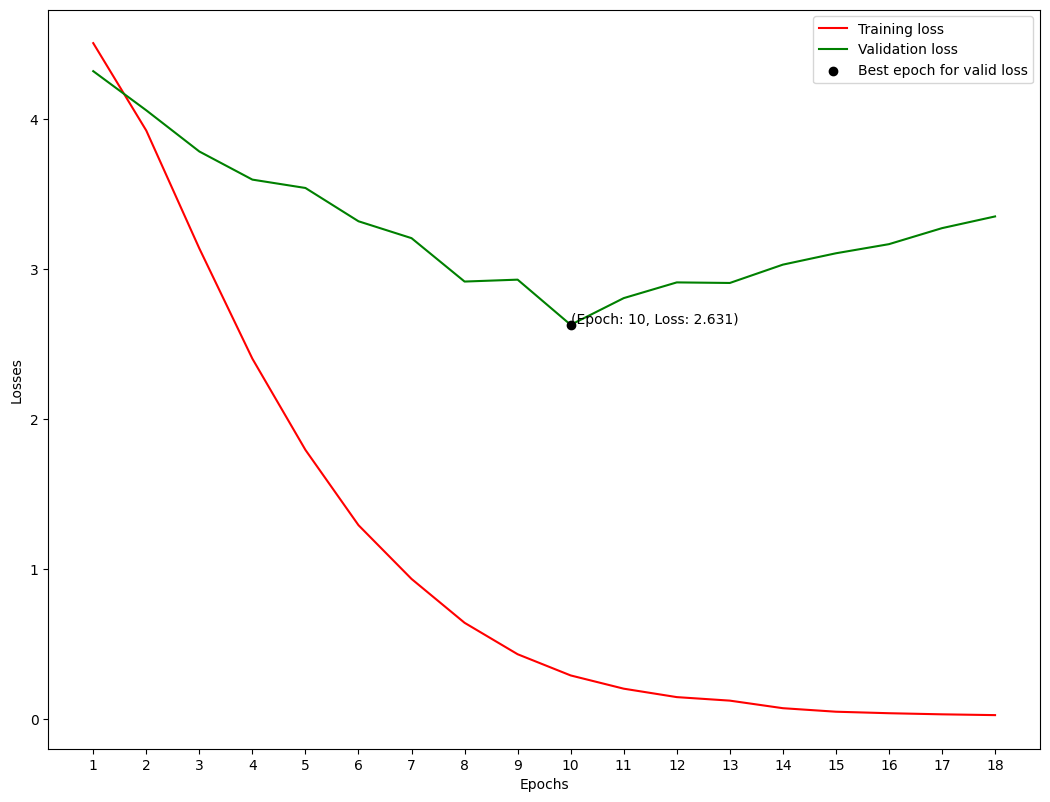

In [ ]:
ep = np.arange(1,epoch+2,1)

print()
print("The lowest loss is at the epoch", np.argmin(valid_losses)+1)

# PLOTS
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
# Validation and training curve
plt.plot(ep, train_losses, c = "red", label = "Training loss")
plt.plot(ep, valid_losses, c = "green", label = "Validation loss")
# Best epoch fot validation loss
plt.scatter(np.argmin(valid_losses)+1, valid_losses[np.argmin(valid_losses)], 
            c = "black", label = "Best epoch for valid loss", zorder=3)
plt.text(np.argmin(valid_losses)+1 + 0.01, valid_losses[np.argmin(valid_losses)] + 0.01, 
         '(Epoch: {}, Loss: {})'.format(np.argmin(valid_losses)+1, 
                                        np.round(valid_losses[np.argmin(valid_losses)], 3)), 
         zorder=4)
# Esthetics
plt.xticks(ep)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

Test - Batch:   0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(98, 98)
F1 score: 0.5216361210896335
Accuracy: 0.5254988913525499
Precision: 0.5506536903911852
Recall: 0.5254988913525499


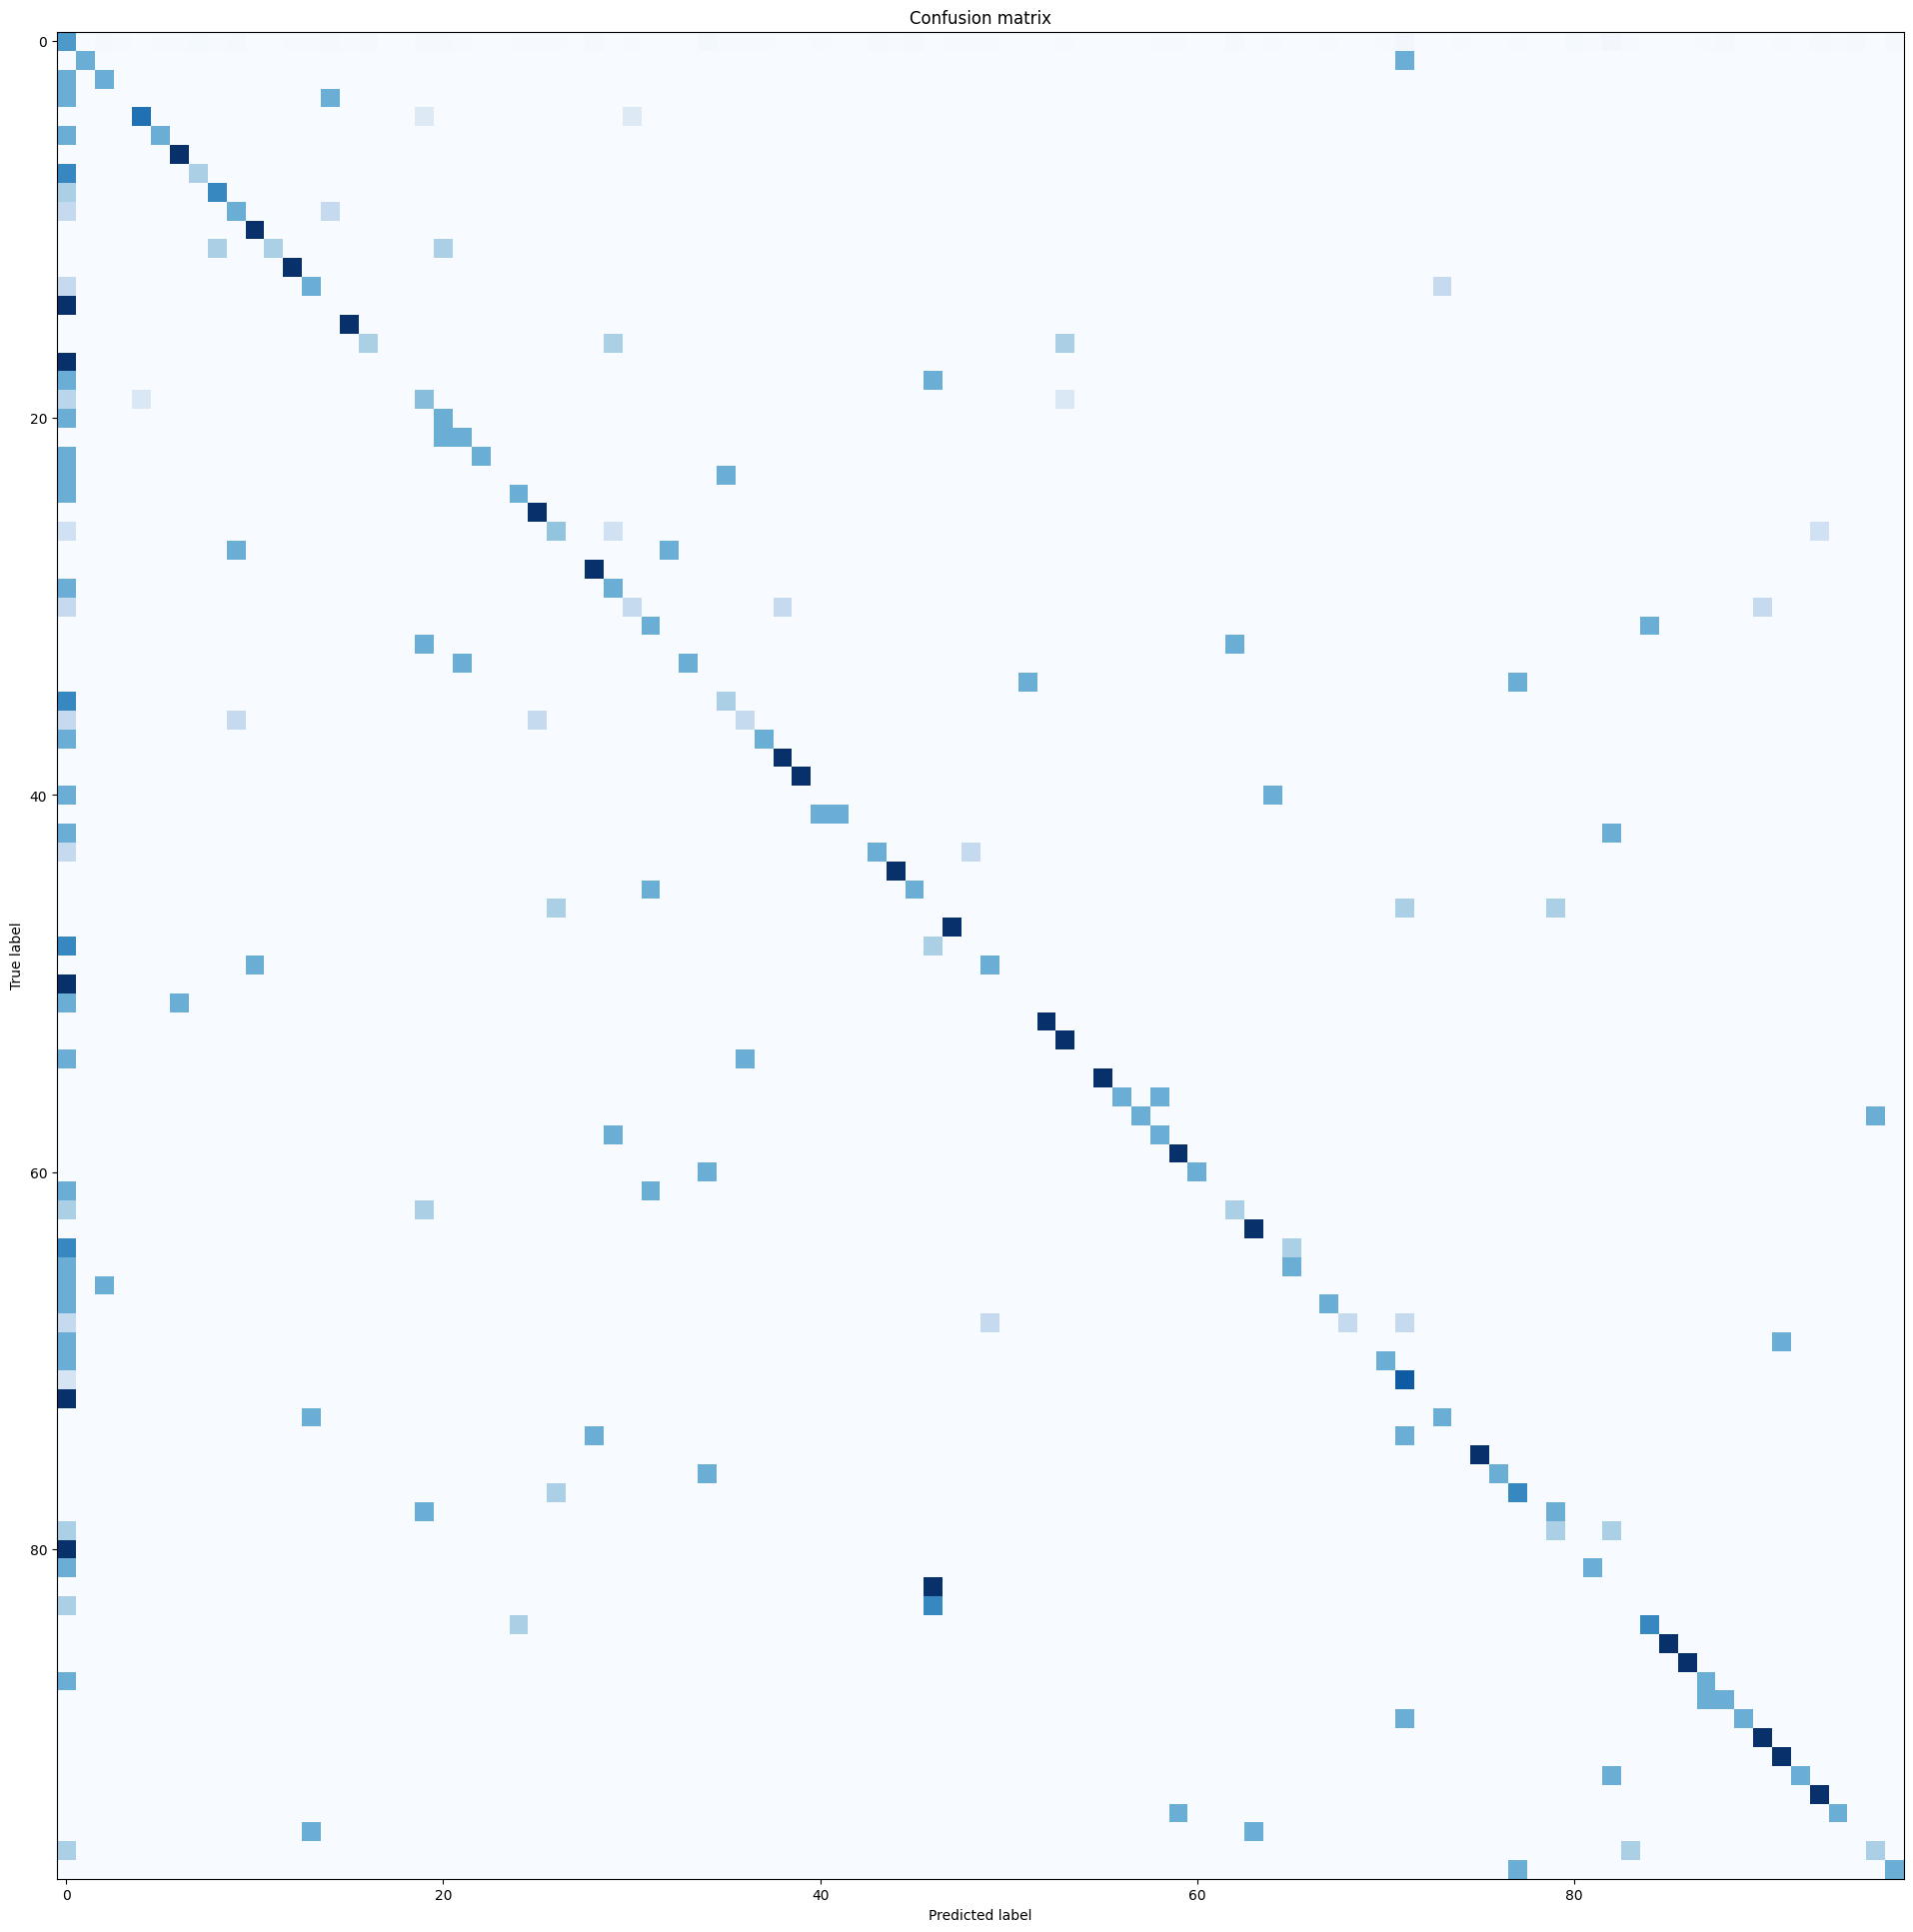

In [ ]:
f1, accuracy, precision, recall, cm = trainer.test(test_data_loader)

print(cm.shape)
# Creo il plot
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
# plt.show()

print("F1 score:", f1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

#Classification Step
1.   We pass as input to the model each synset of final dataset, containing the ambiguous ones. Each synset is associated with the possible belonging frames.
2.   From the predictions, we take those at the indices (LABEL_TO_ID/ID_TO_LABEL) of the ambiguous frames.
3. From the predictions, we take those at the indices (LABEL_TO_ID/ID_TO_LABEL) of the ambiguous frames.

The synset is not disambiguated in the following cases:

*   The prediction value given by step 3 is less than a certain threshold.
*   If at least one frame associated to the input synset was not used to train the network.

In [ ]:
# load checkpoint 
checkpoint_path = CHECKPOINTS_PATH + 'Event_classification_model.pt'
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(DEVICE)

In [ ]:
no_sample = []
count = 0
not_sure_counter = 0
not_enough_information_counter = 0
results = {}
for i in tqdm(range(len(final_dataset)), desc = "element", leave = False):
    # Model input
    input_ids = final_dataset[i]["transformer_inputs"]["input_ids"]
    input_ids = input_ids.unsqueeze(0)
    attention_mask = final_dataset[i]["transformer_inputs"]["attention_mask"]
    attention_mask = attention_mask.unsqueeze(0)
    token_type_ids = final_dataset[i]["transformer_inputs"]["token_type_ids"]
    token_type_ids = token_type_ids.unsqueeze(0)
    pos_idx = final_dataset[i]["pos_idx"]
    pos_idx = pos_idx.unsqueeze(0)
    verb_frame_idx = final_dataset[i]["verb_frame_idx"]
    verb_frame_idx = verb_frame_idx.unsqueeze(0)
    model_input = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "token_type_ids": token_type_ids,
        "pos_idx": pos_idx,
        "verb_frame_idx": verb_frame_idx, 
        "compute_loss": False
    }
    pred_all = model(**model_input)["classification"][0]
    
    # Softmax
    pred_all = model(**model_input)["classification"][0].cpu().detach().numpy()
    pred_all = np.exp(-np.array(pred_all)) + 1e-30
    pred_all /= np.sum(pred_all)
    pred_all = [pred_all[label_id] for label_id in label_ids]
    
    # Predicted index frame 
    pred = np.argmax(pred_all)

    # Postprocessing
    synset = final_dataset.synsets[i][8:-2]
    label_ids = []
    other_id = -1
    frame_not_in_labels = False
    for frame in final_dataset.labels[i]:
        if frame in LABEL_OTHER:
            label_ids.append(LABEL_TO_ID["other"])
            other_id = LABEL_OTHER_TO_ID[frame]
        elif frame in LABEL:
            label_ids.append(LABEL_TO_ID[frame])
        else:
            no_sample.append(frame)
            frame_not_in_labels = True
    if frame_not_in_labels:
        not_enough_information_counter += 1
        continue
    if pred_all[pred] > 0.002:
        count += 1
        results[synset] = [[ID_TO_LABEL[label_id] if ID_TO_LABEL[label_id] != "other" else ID_TO_LABEL_OTHER[other_id] for label_id in label_ids]]
        if ID_TO_LABEL[label_ids[pred]] == 'other':
            results[synset].append(ID_TO_LABEL_OTHER[other_id])
        else:
            results[synset].append(ID_TO_LABEL[label_ids[pred]])
    else:
        not_sure_counter += 1
print("Disambiguated synsets:", count)
print("Frame not in training labels, keep the ambiguity:", not_enough_information_counter)
print("Predictions under the threshold, keep the ambiguity:", not_sure_counter)

element:   0%|          | 0/815 [00:00<?, ?it/s]

Disambiguated synsets: 743
Frame not in training labels, keep the ambiguity: 20
Predictions under the threshold, keep the ambiguity: 52


In [ ]:
# Save the dictionary in a JSON file
save_path = OUTPUT_PATH + "event_classification_step_results.json"
with open(save_path, "w") as file:
    json.dump(results, file)

#Other Results

LEARNING_RATE = 5e-4 \
WEIGHT_DECAY = 0.0 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
VERB_FRAME_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.3 \
NUM_LABEL_OCCURENCIES = 10 \


The lowest loss is at the epoch 11


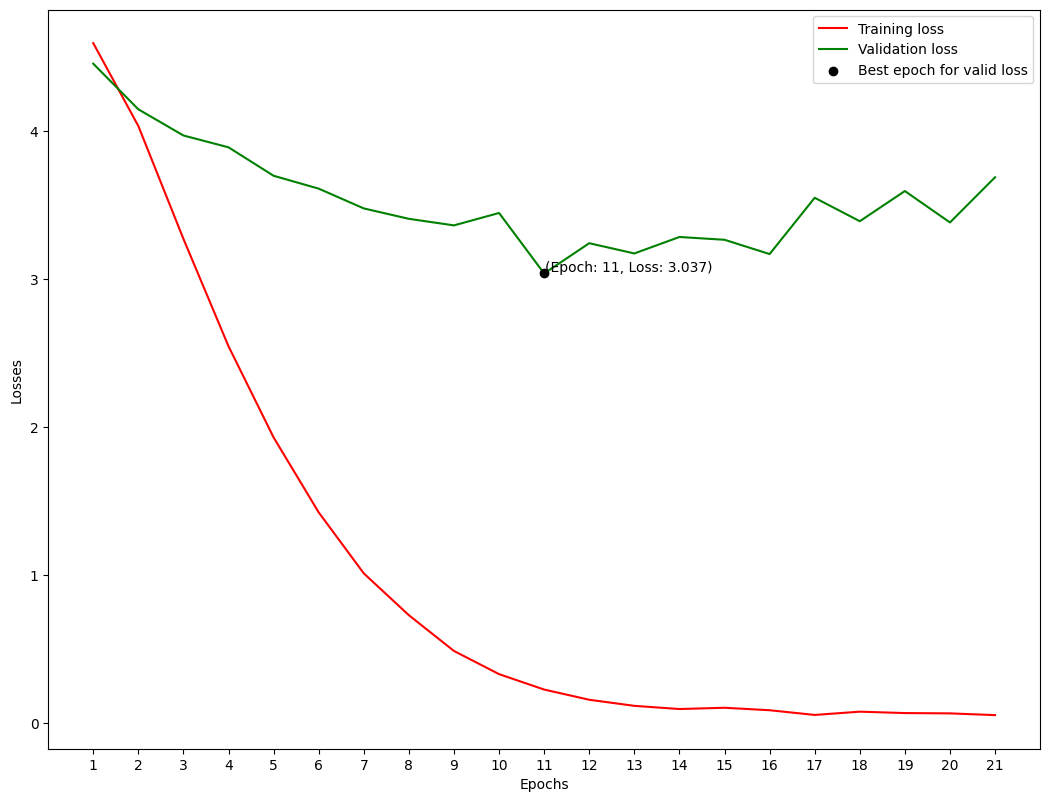

In [ ]:
# Plot

Test - Batch:   0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(107, 107)
F1 score: 0.41119201598137595
Accuracy: 0.4124168514412417
Precision: 0.4650799403848184
Recall: 0.4124168514412417


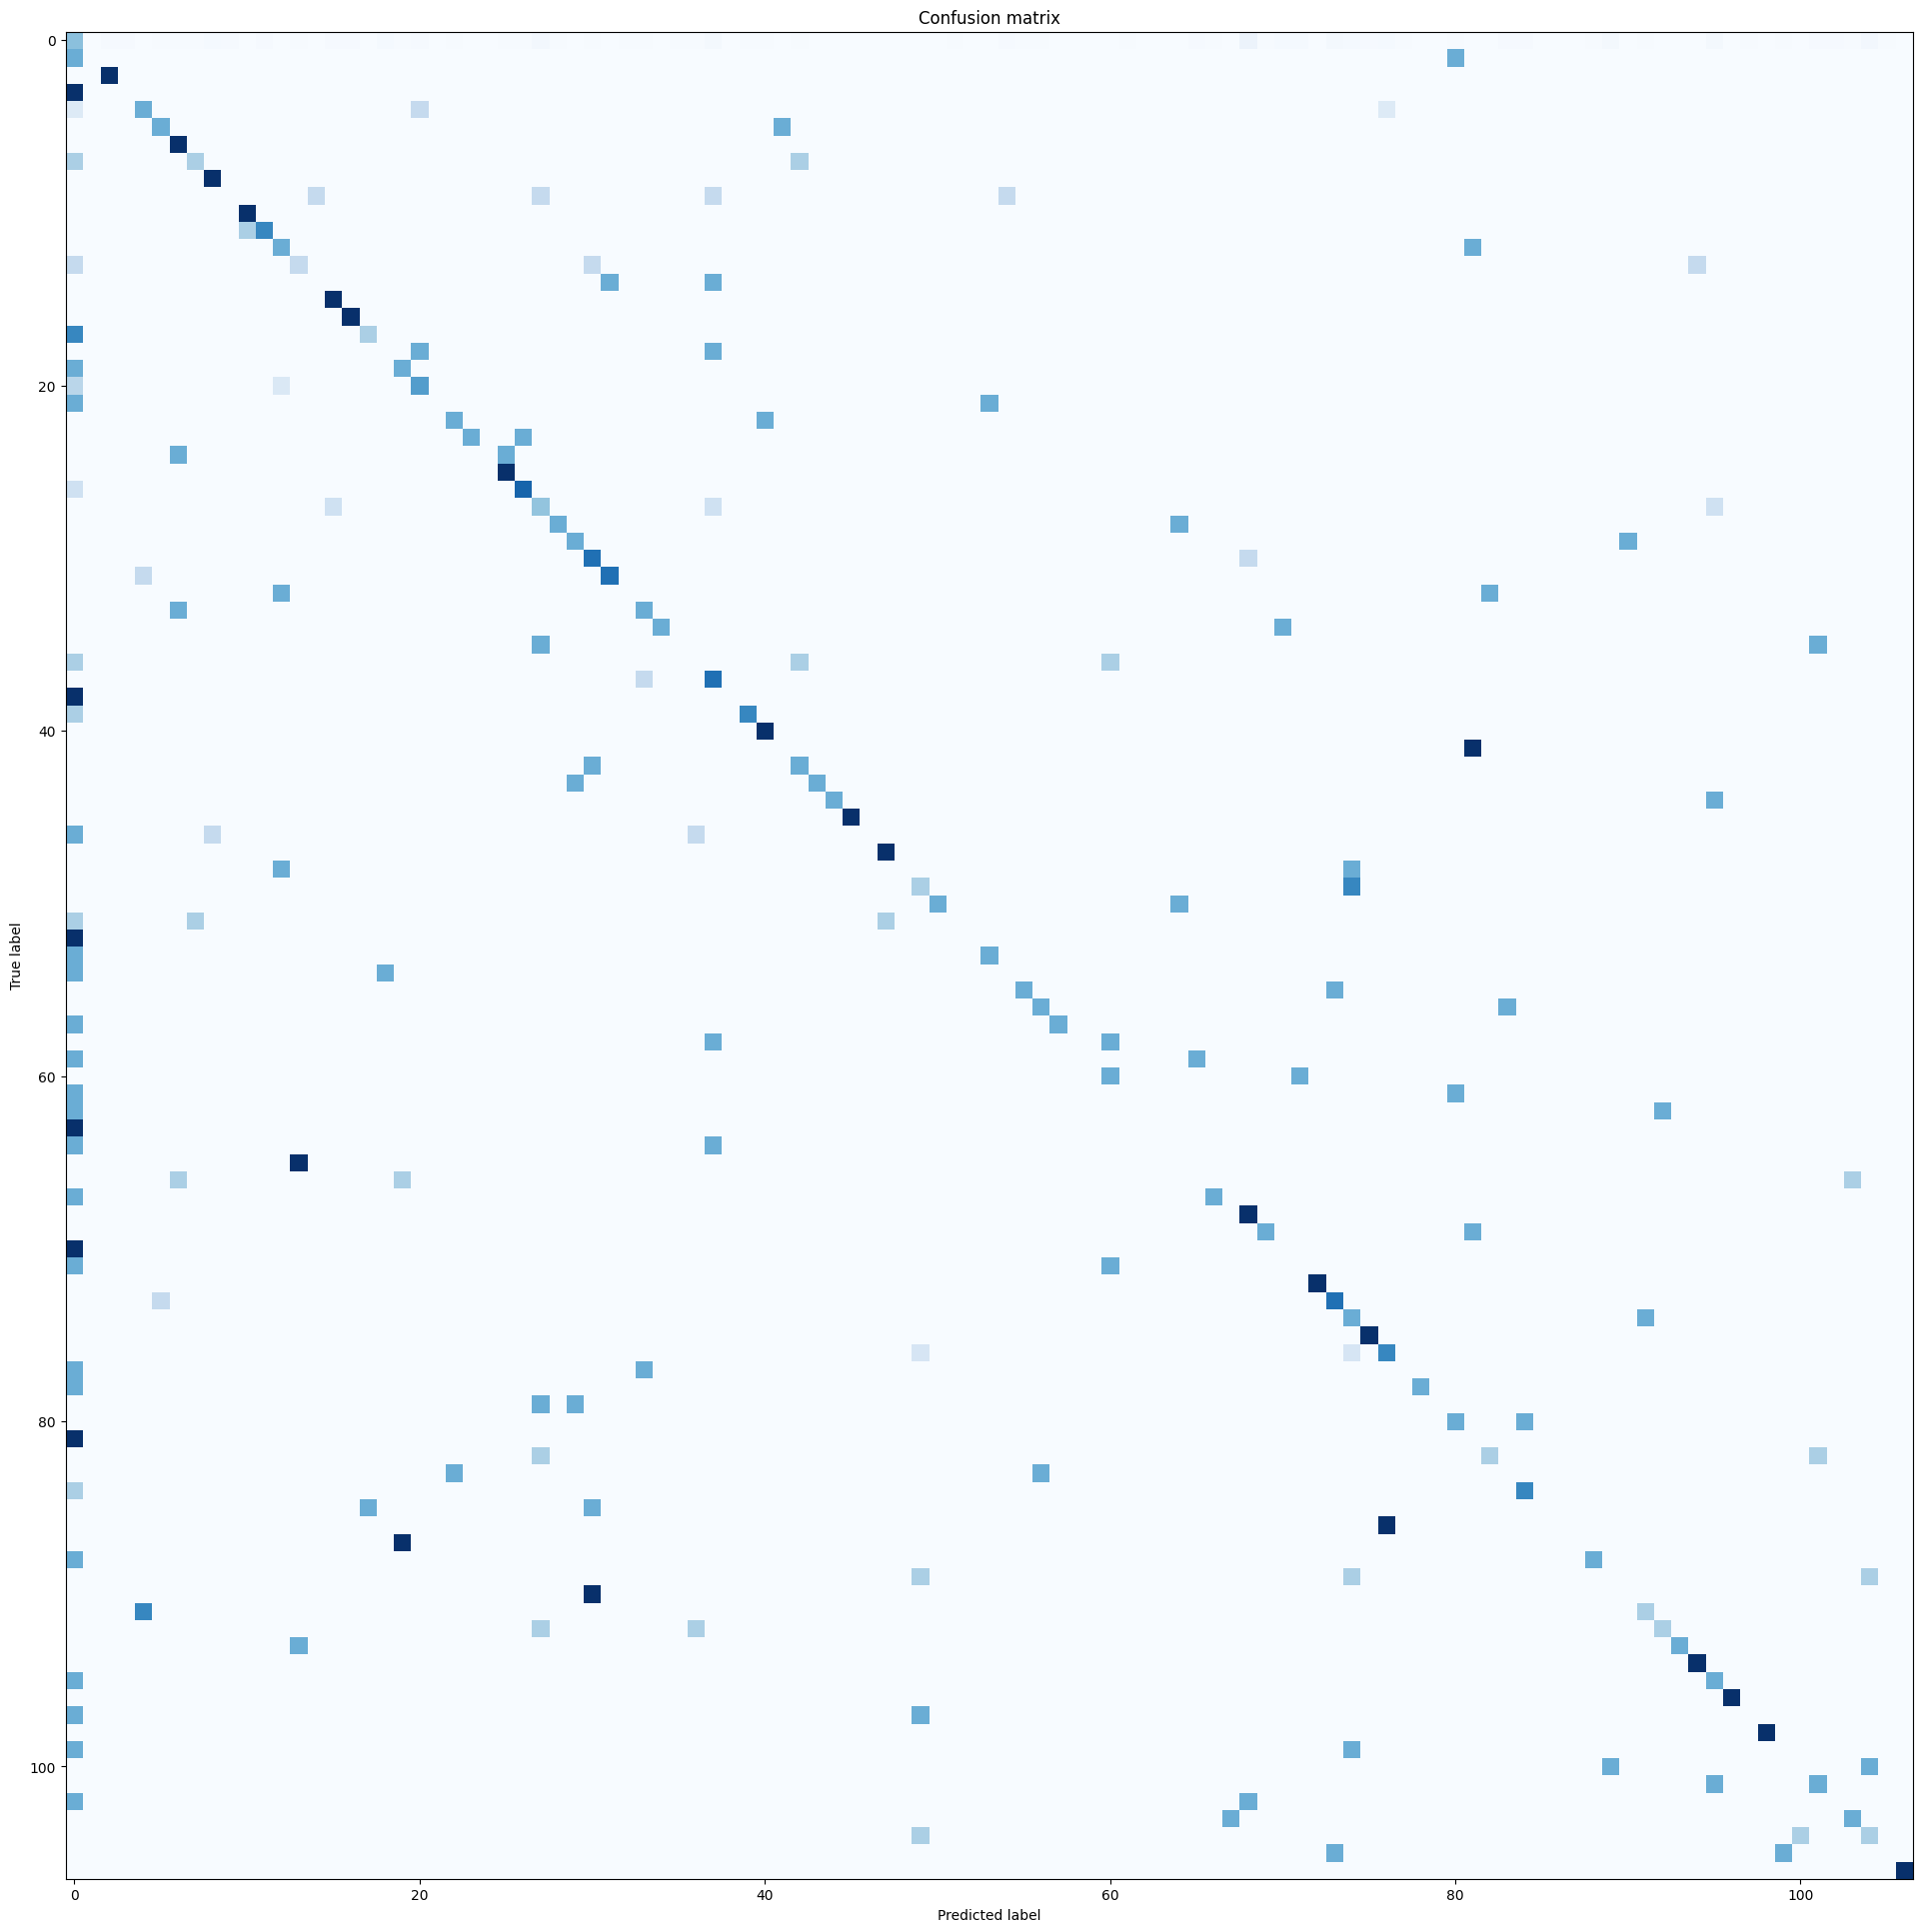

In [ ]:
# Confusion Matrix and results

LEARNING_RATE = 5e-4 \
WEIGHT_DECAY = 0.0 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
VERB_FRAME_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.3 \
NUM_LABEL_OCCURENCIES = 12 \


The lowest loss is at the epoch 14


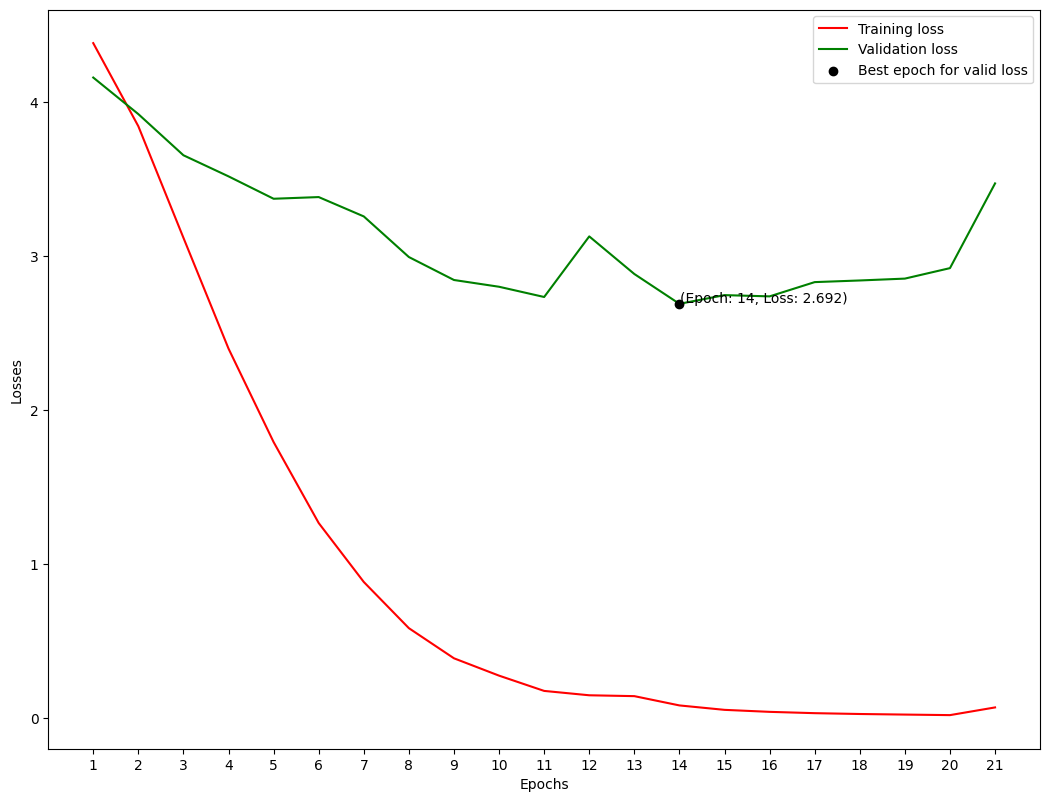

In [ ]:
# Plot

Test - Batch:   0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(86, 86)
F1 score: 0.43159145875949945
Accuracy: 0.41019955654101997
Precision: 0.5472362188803529
Recall: 0.41019955654101997


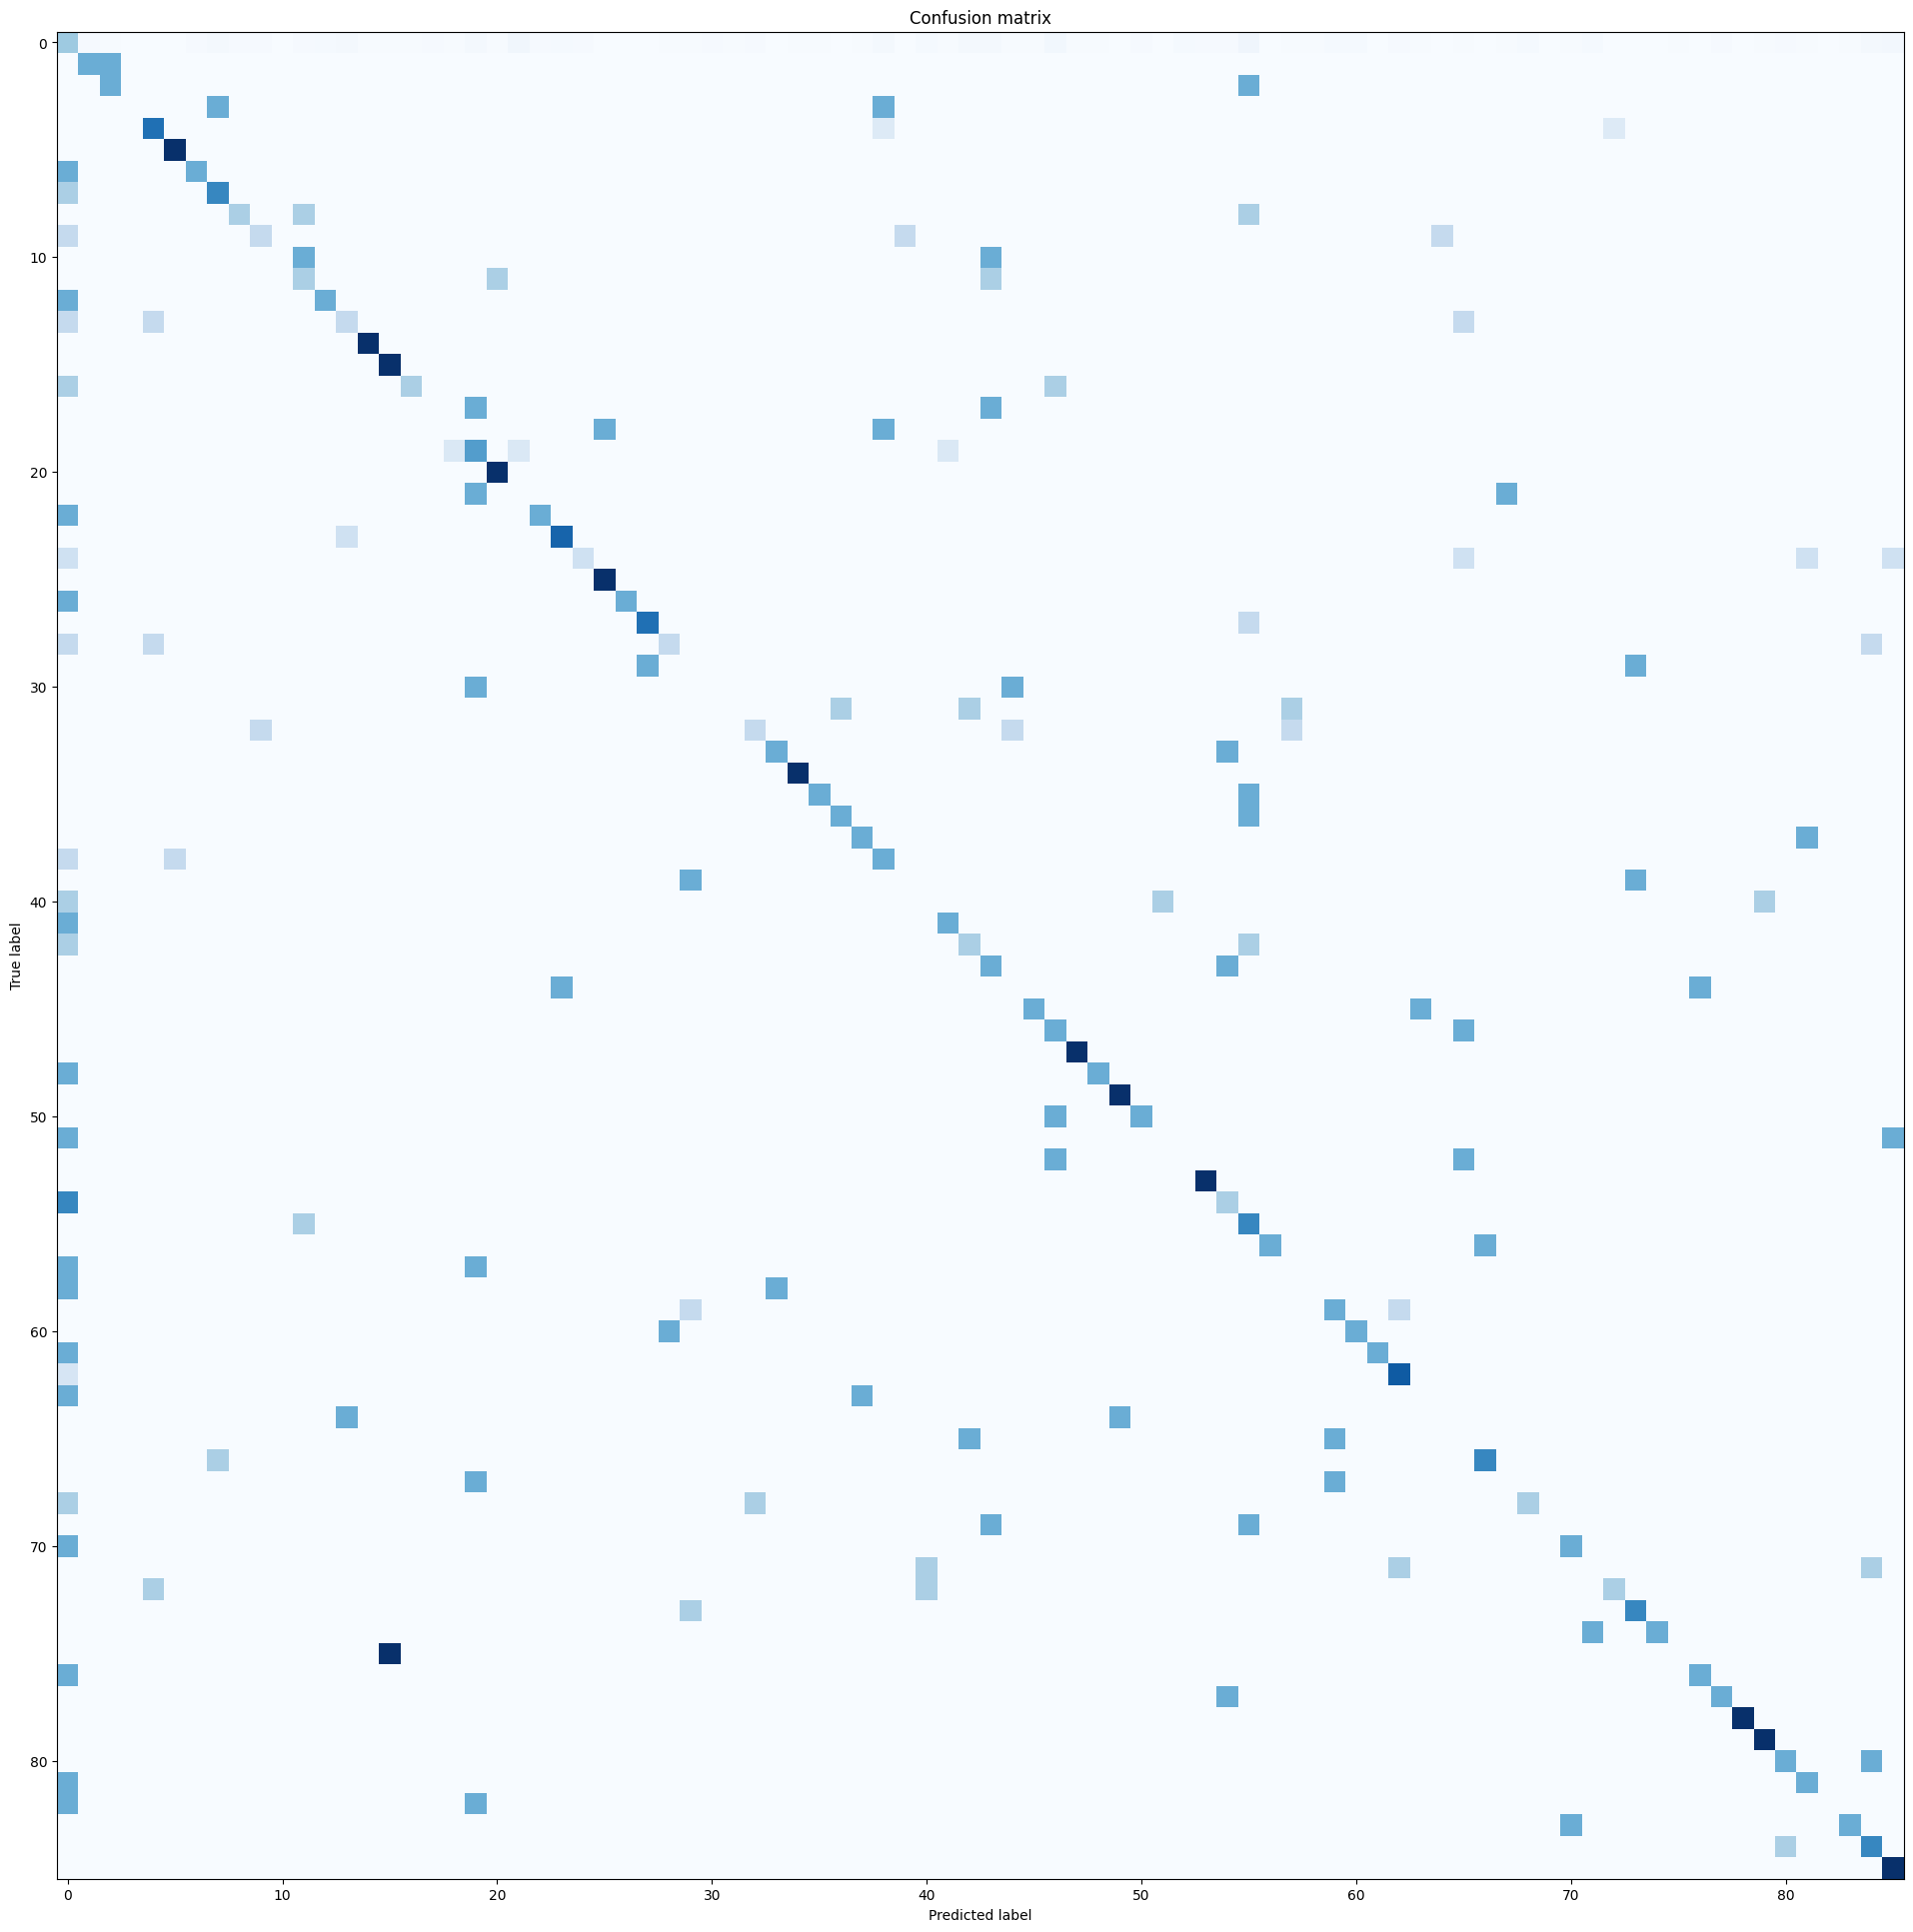

In [ ]:
# Confusion Matrix and results

LEARNING_RATE = 5e-5  \
WEIGHT_DECAY = 0.002 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
VERB_FRAME_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.3 \
NUM_LABEL_OCCURENCIES = 11 \


The lowest loss is at the epoch 11


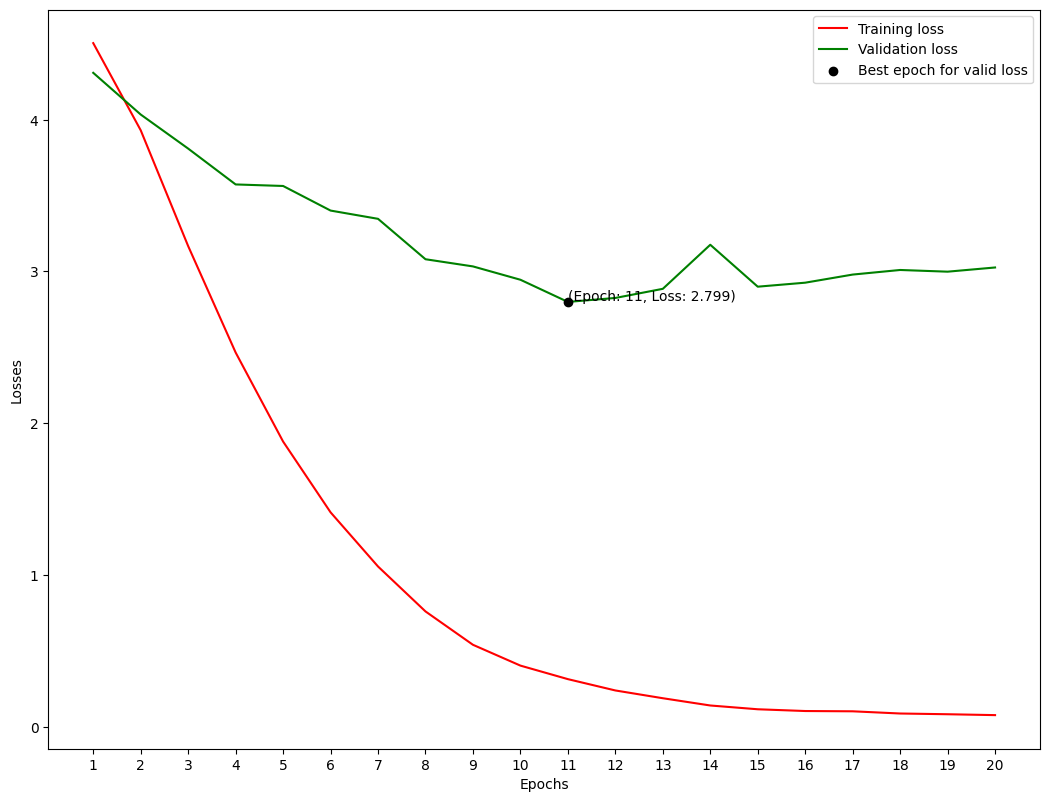

In [ ]:
# Plot

Test - Batch:   0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(98, 98)
F1 score: 0.5084171809052191
Accuracy: 0.5121951219512195
Precision: 0.53881218521651
Recall: 0.5121951219512195


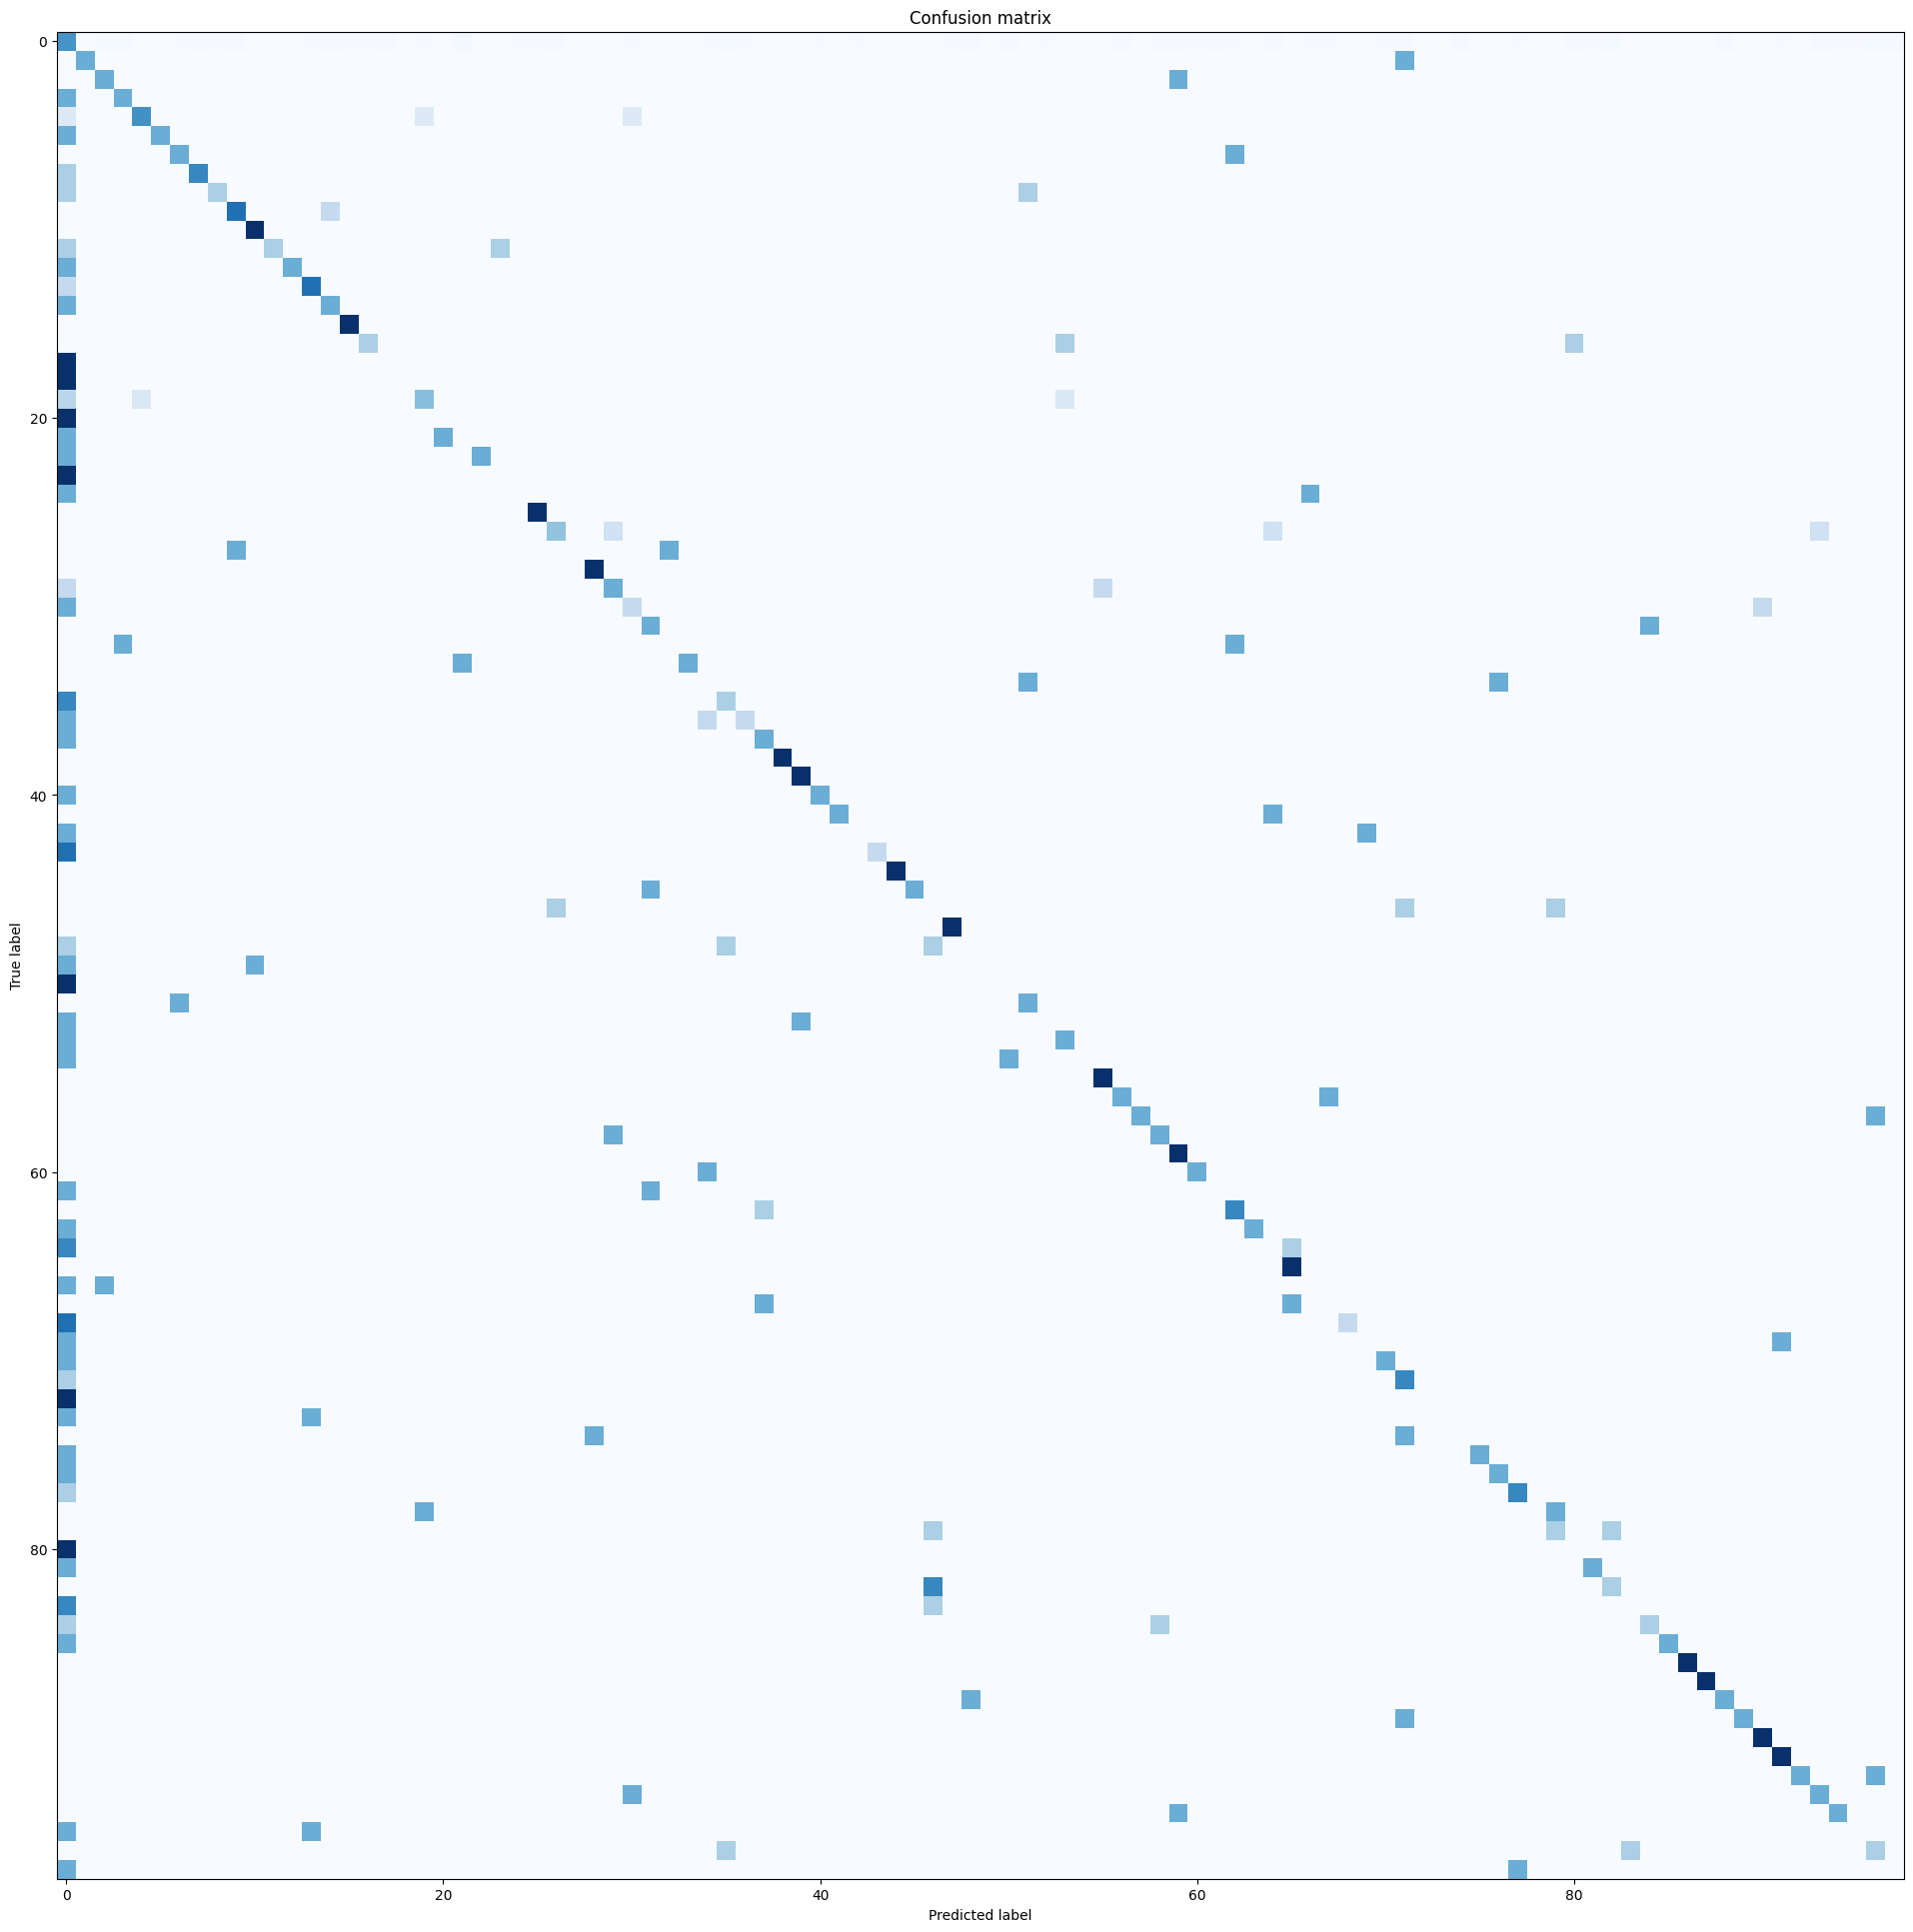

In [ ]:
# Confusion Matrix and results

LEARNING_RATE = 5e-5  \
WEIGHT_DECAY = 0.001 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
VERB_FRAME_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 3 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.3 \
NUM_LABEL_OCCURENCIES = 11 \



The lowest loss is at the epoch 14


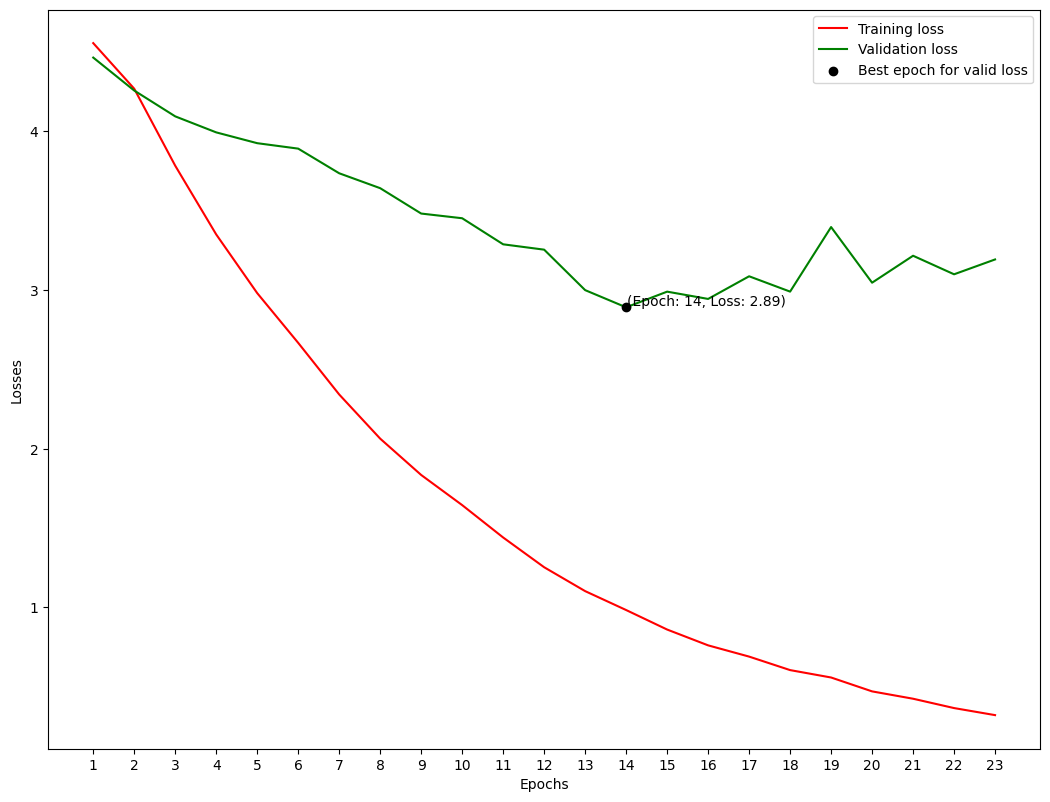

In [ ]:
# Plot

Test - Batch:   0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(98, 98)
F1 score: 0.4928382338244261
Accuracy: 0.4878048780487805
Precision: 0.5355226997688194
Recall: 0.4878048780487805


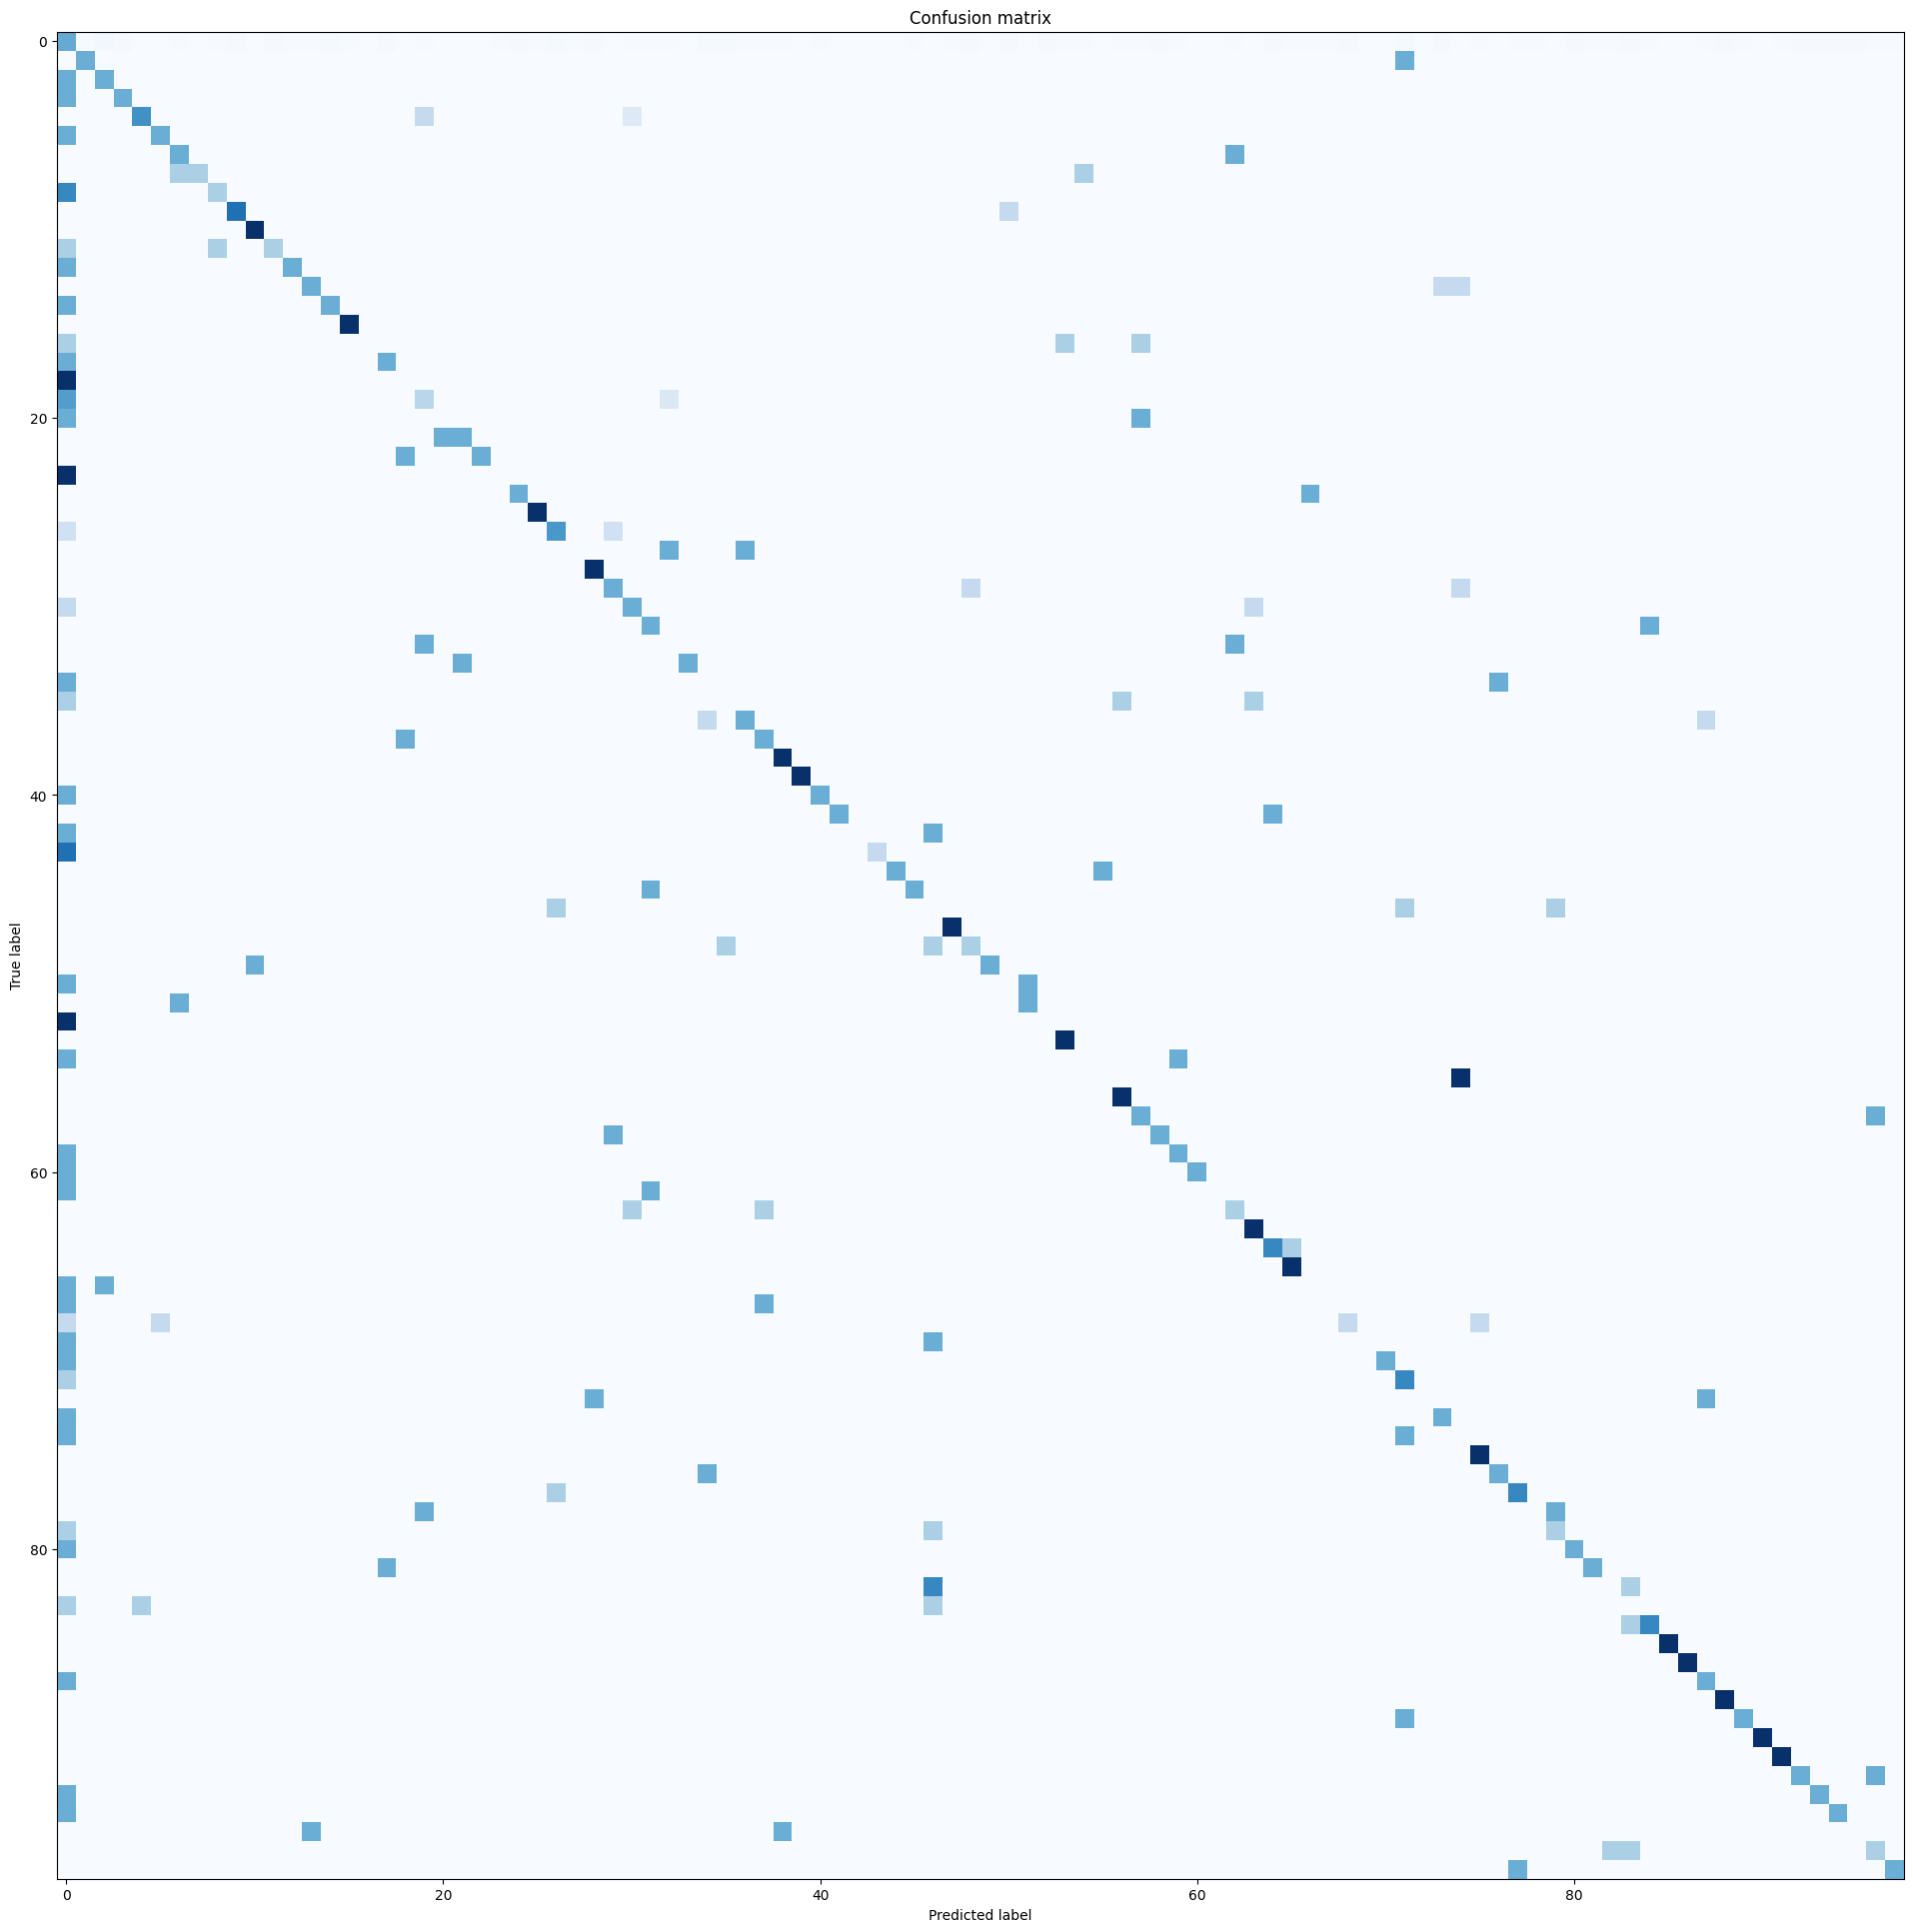

In [ ]:
# Confusion Matrix and results

LEARNING_RATE = 5e-5  \
WEIGHT_DECAY = 0.001 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
VERB_FRAME_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.3 \
NUM_LABEL_OCCURENCIES = 11 \




The lowest loss is at the epoch 12


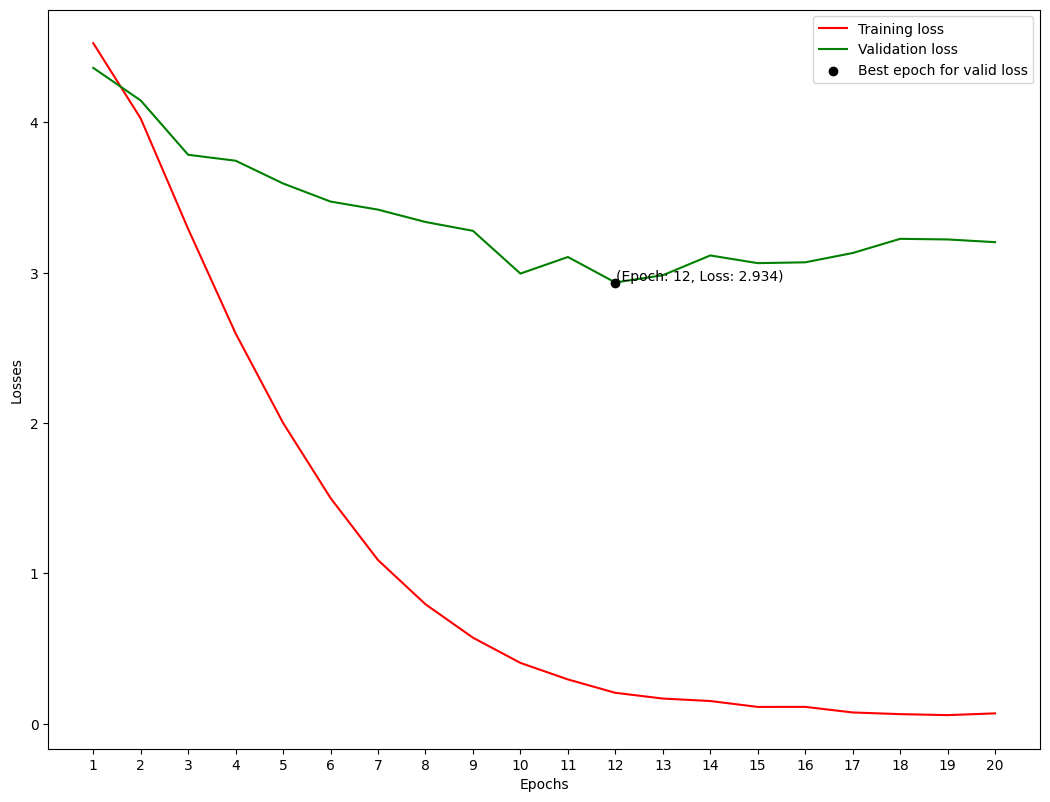

In [ ]:
# Plot

Test - Batch:   0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(98, 98)
F1 score: 0.5072396152597891
Accuracy: 0.5077605321507761
Precision: 0.5442319706974065
Recall: 0.5077605321507761


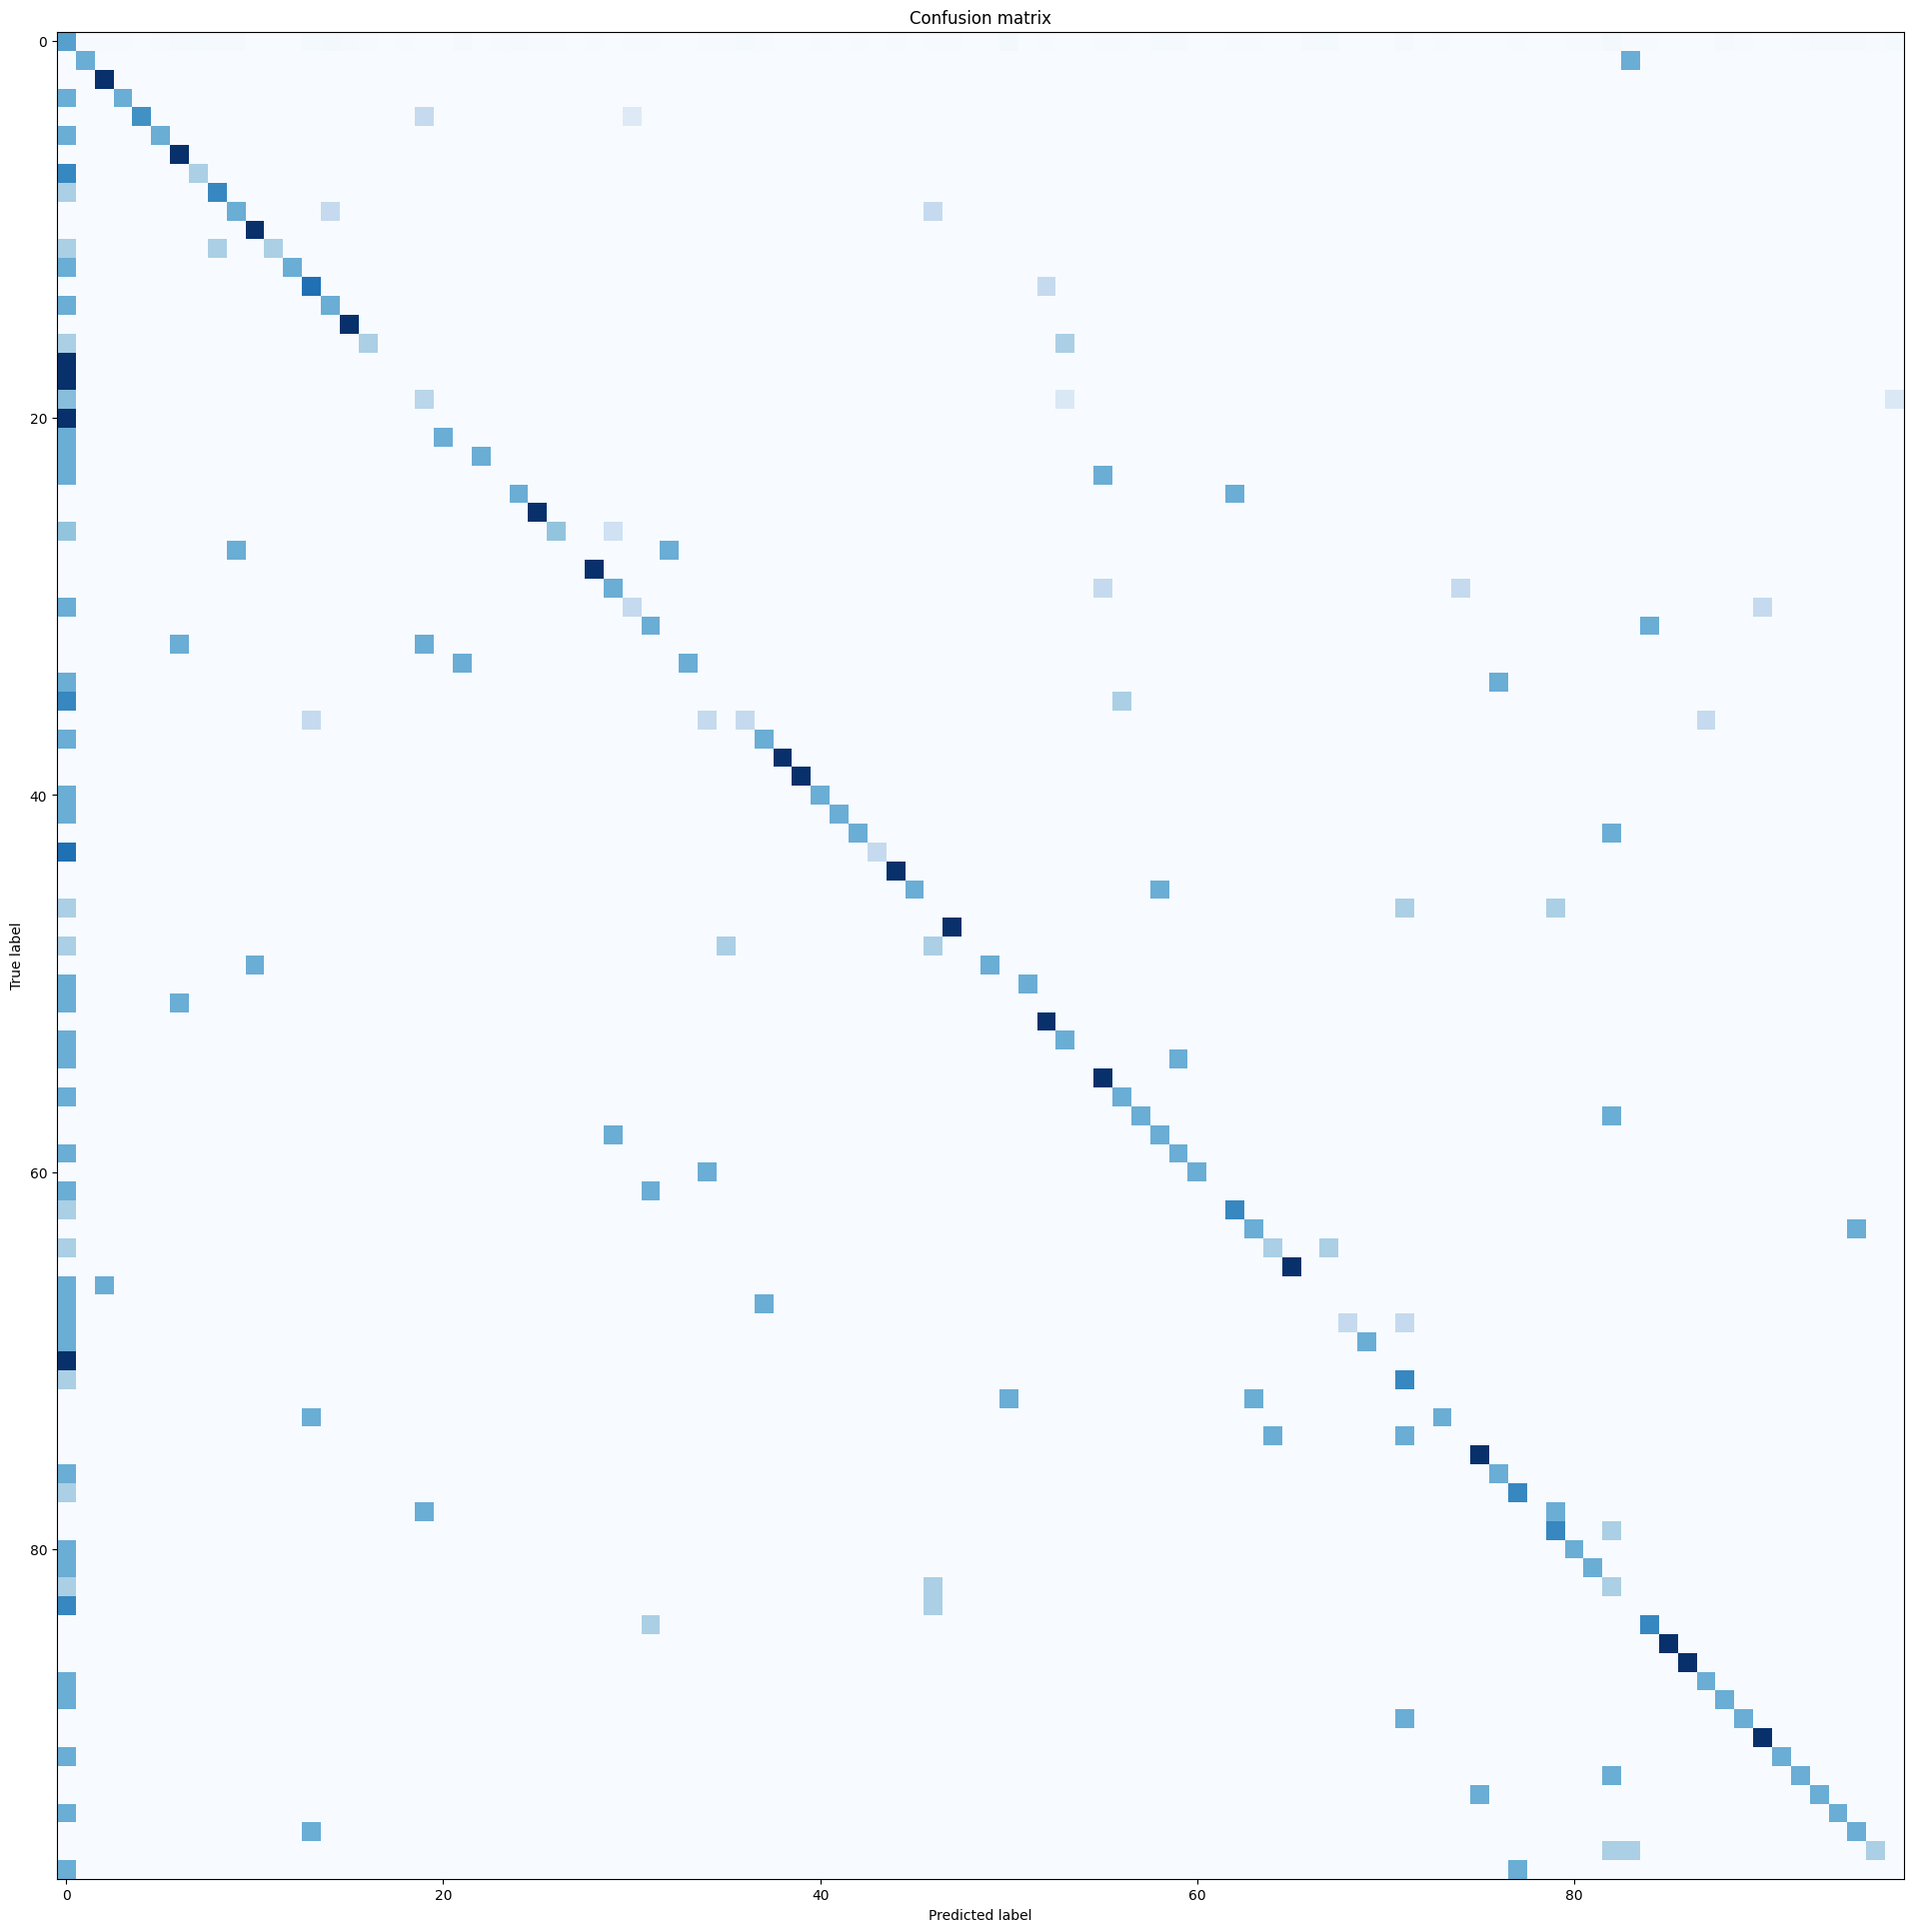

In [ ]:
# Confusion Matrix and results

LEARNING_RATE = 5e-5  \
WEIGHT_DECAY = 0.0 \
TRANSFORMER_LEARNING_RATE = 4e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
VERB_FRAME_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.4 \
NUM_LABEL_OCCURENCIES = 11 \





The lowest loss is at the epoch 13


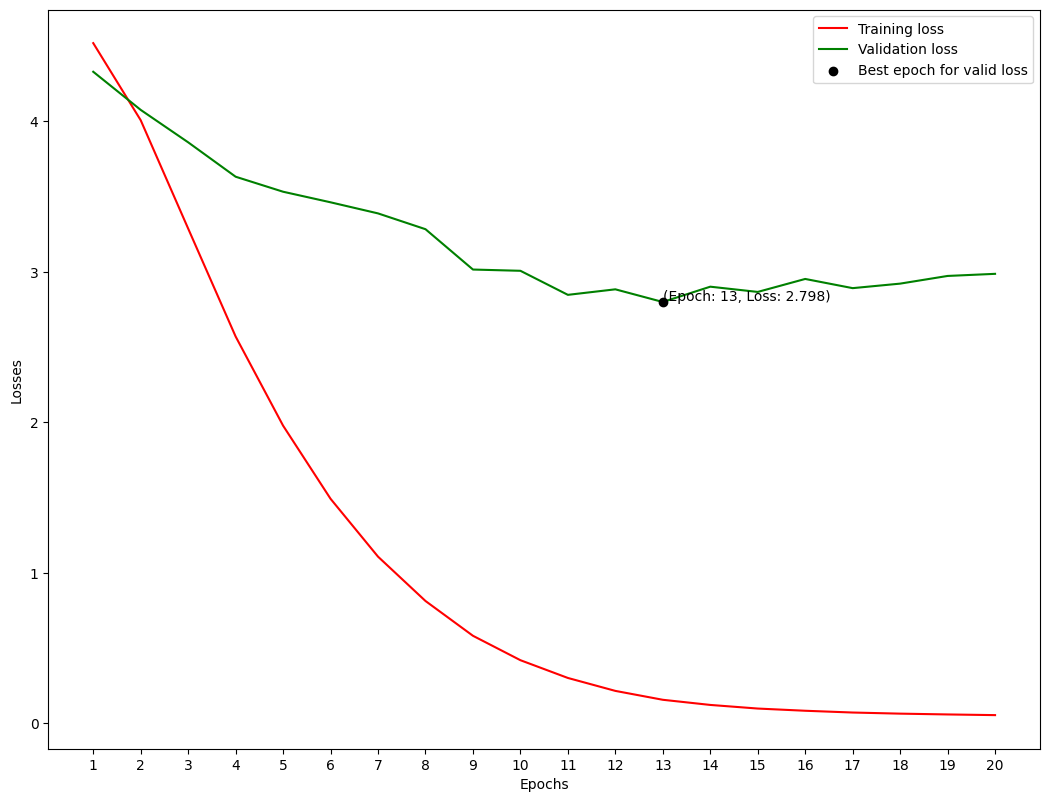

In [ ]:
# Plot

Test - Batch:   0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(98, 98)
F1 score: 0.49128835942036064
Accuracy: 0.5055432372505543
Precision: 0.4980881830660101
Recall: 0.5055432372505543


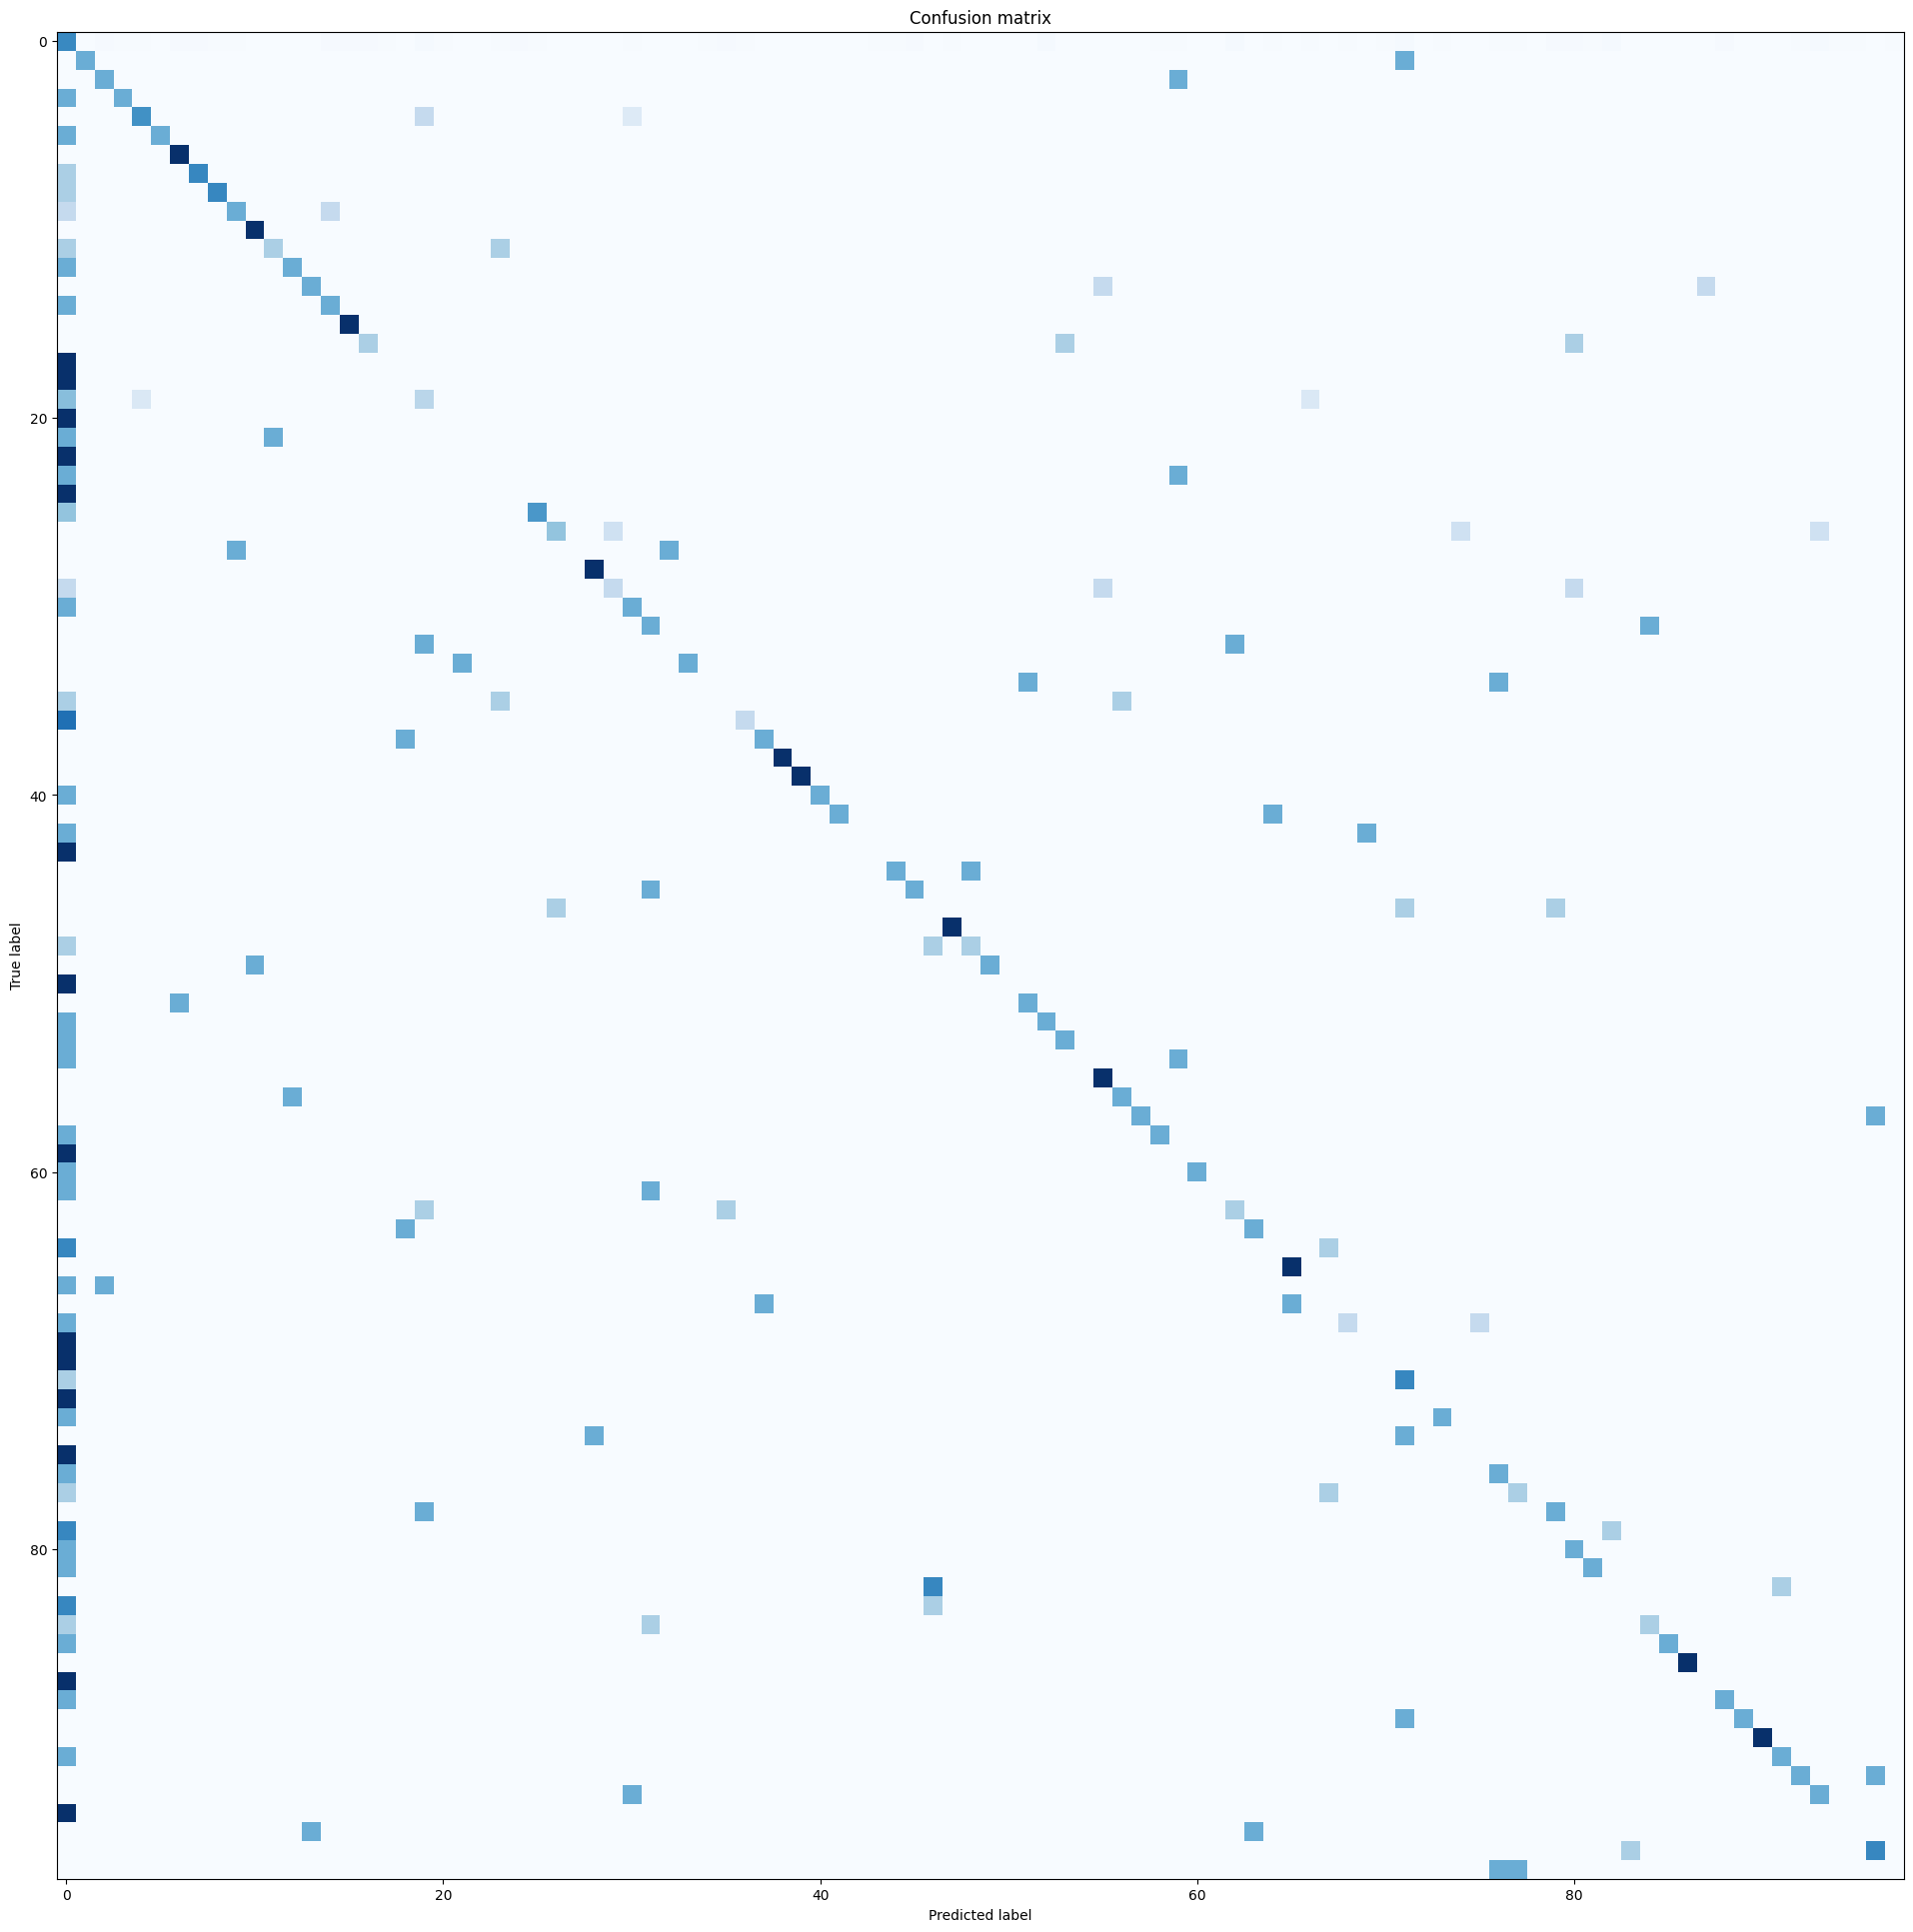

In [ ]:
# Confusion Matrix and results

LEARNING_RATE = 5e-5  \
WEIGHT_DECAY = 0.001 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
VERB_FRAME_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.4 \
NUM_LABEL_OCCURENCIES = 11 \



The lowest loss is at the epoch 14


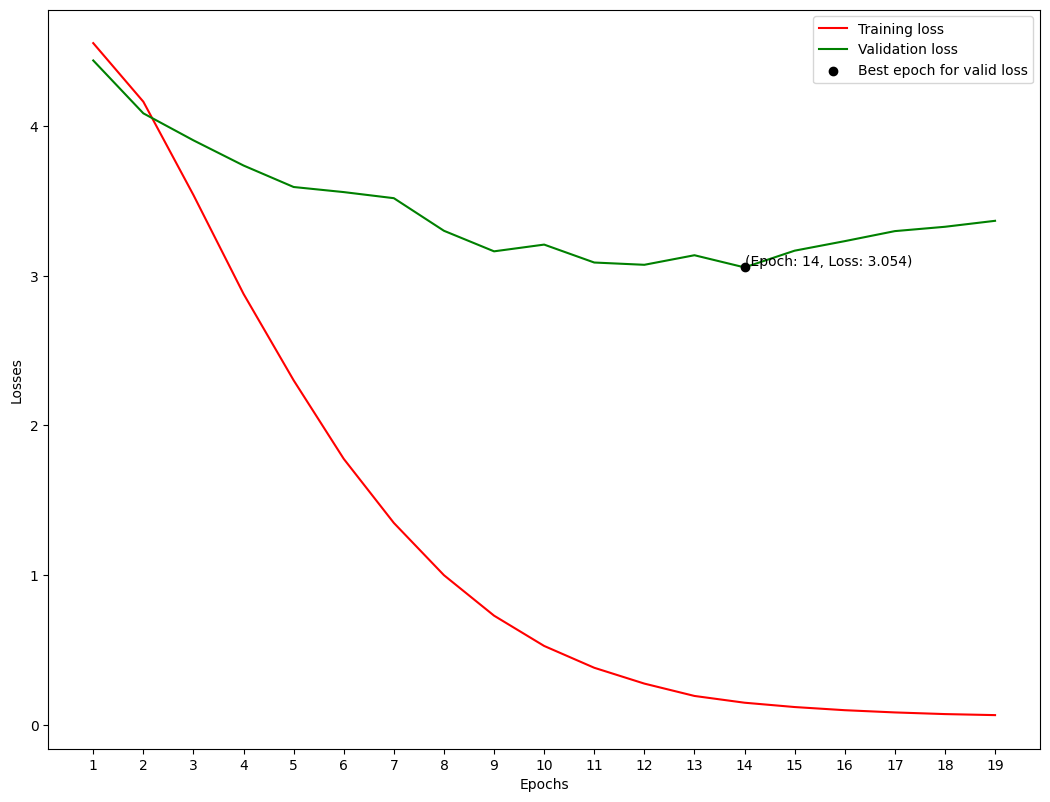

In [ ]:
# Plot

Test - Batch:   0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(98, 98)
F1 score: 0.49941048696754975
Accuracy: 0.5055432372505543
Precision: 0.5213245160436221
Recall: 0.5055432372505543


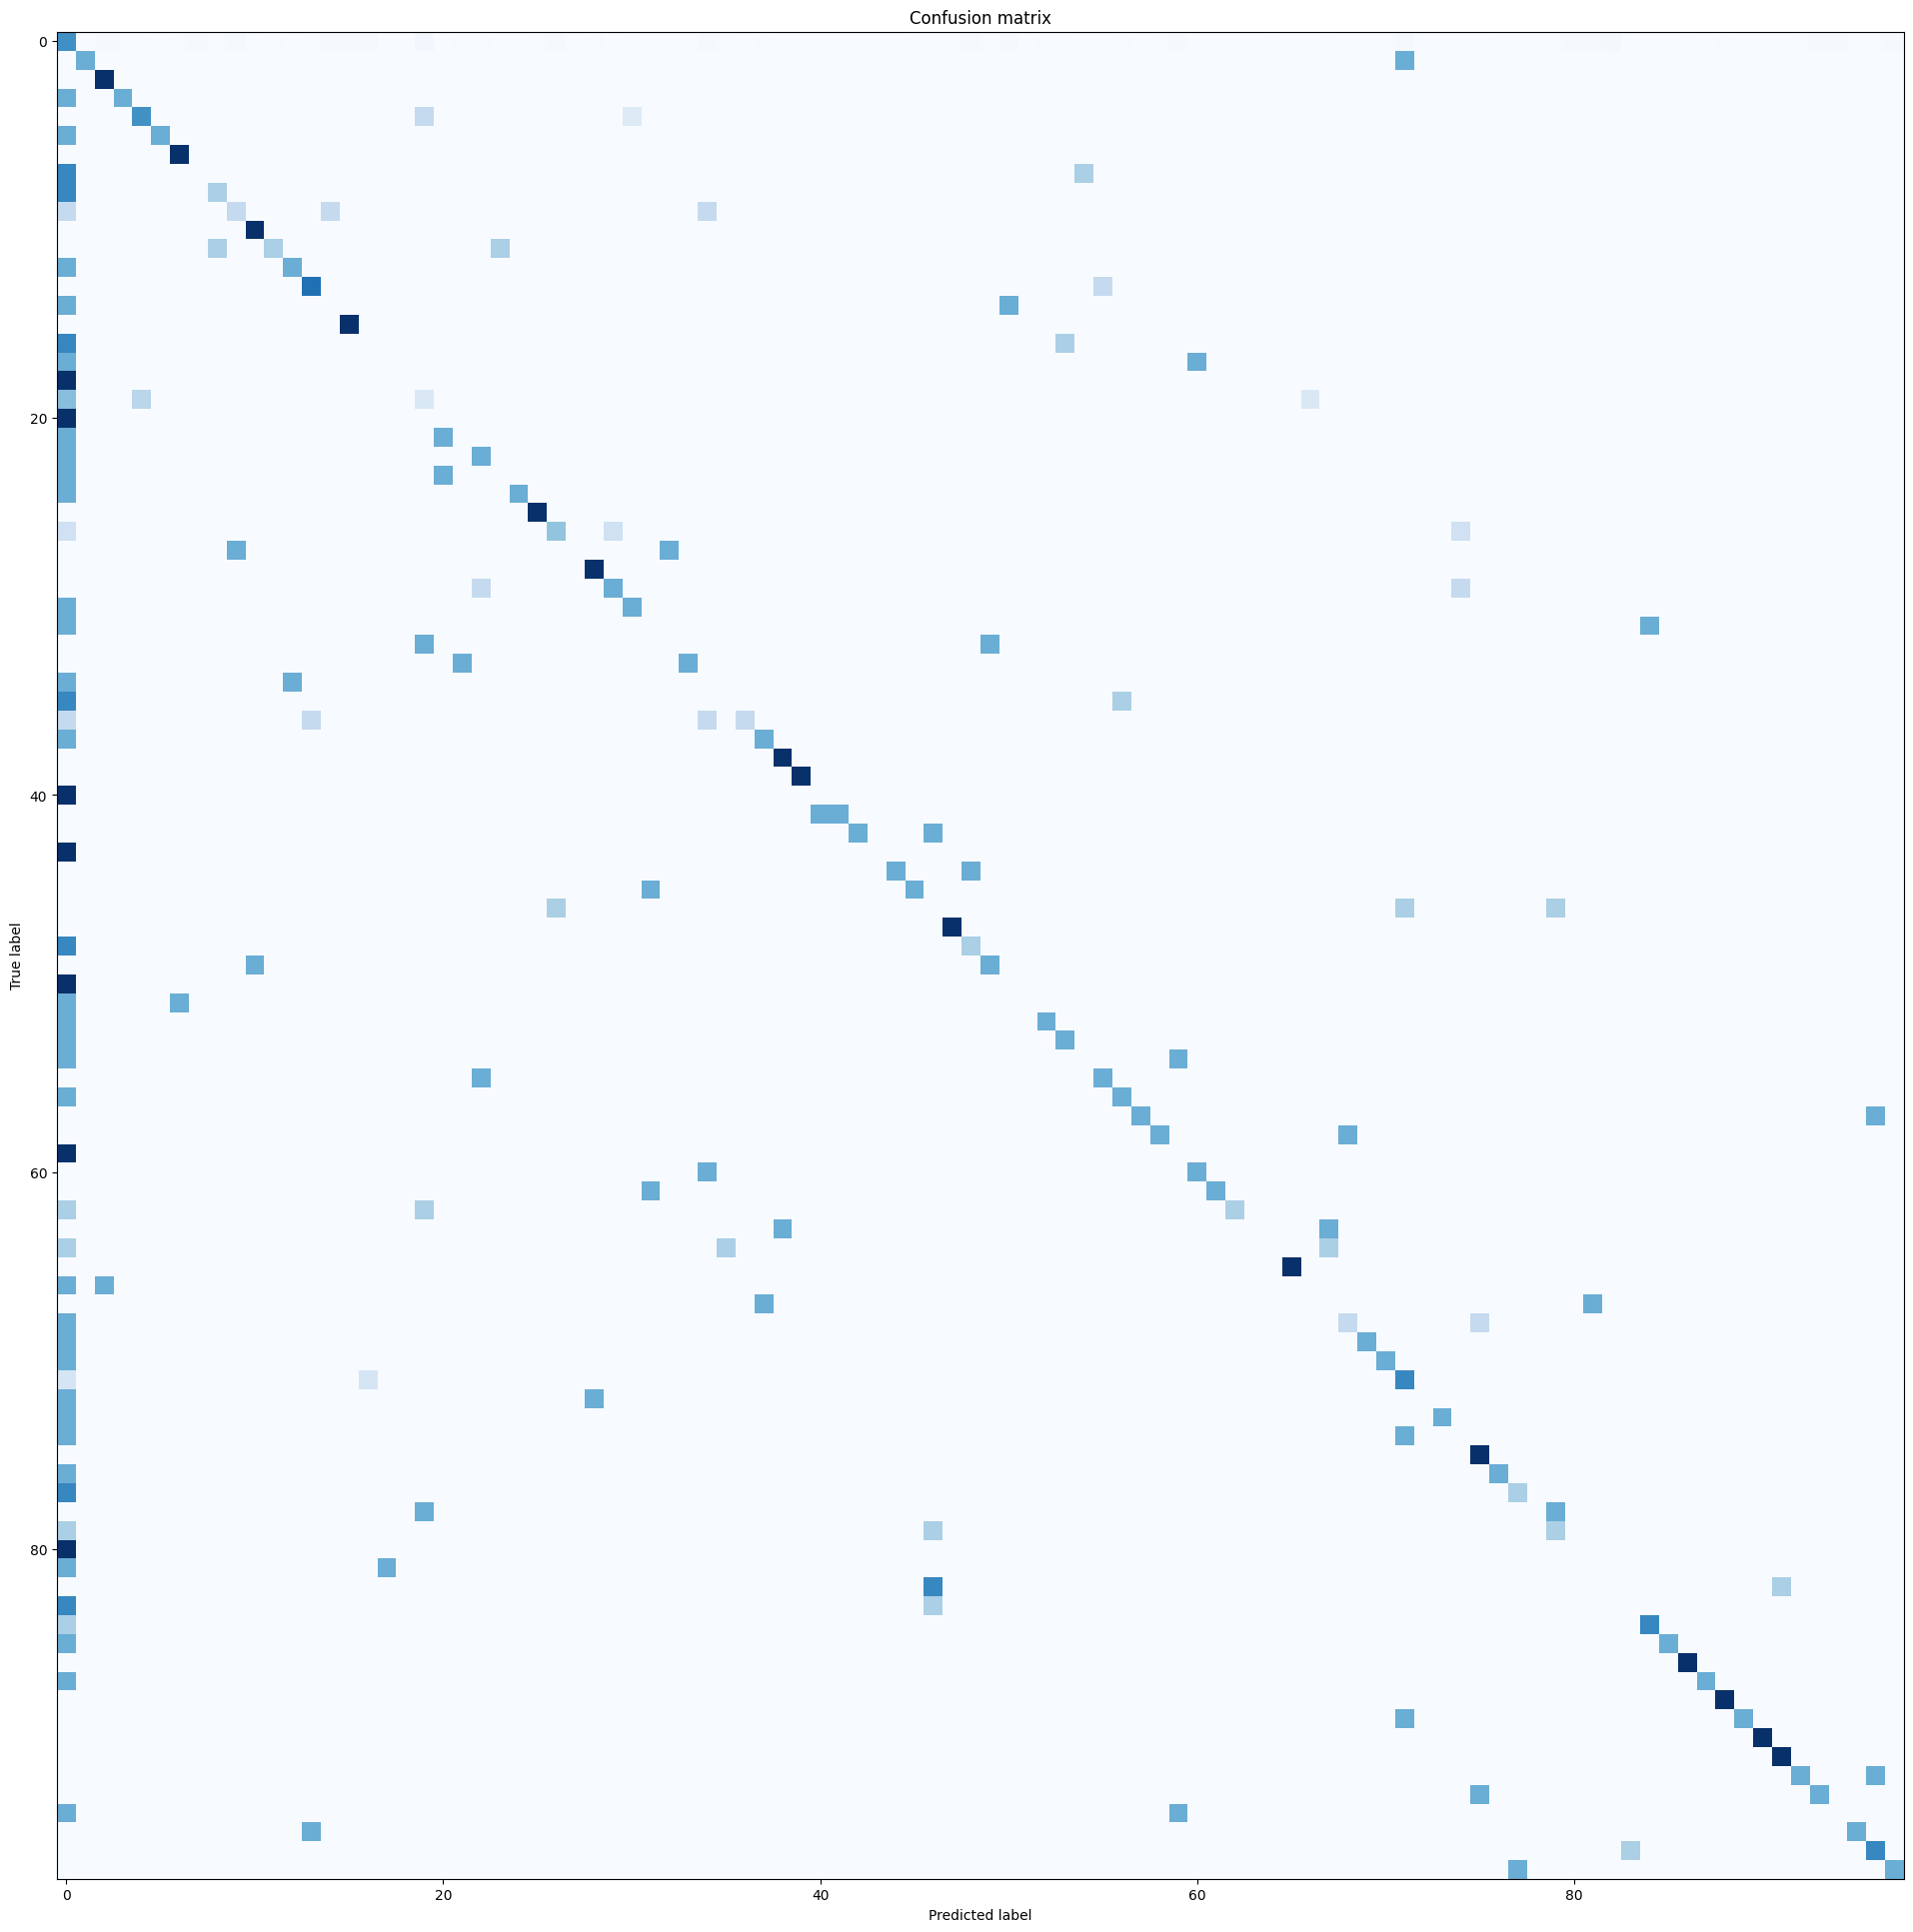

In [ ]:
# Confusion Matrix and results

LEARNING_RATE = 5e-5  \
WEIGHT_DECAY = 0.001 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
VERB_FRAME_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.4 \
NUM_LABEL_OCCURENCIES = 4 \
WEIGHTS_TYPE = Log softmax \
TRANSFORMER = bert-large \


The lowest loss is at the epoch 1


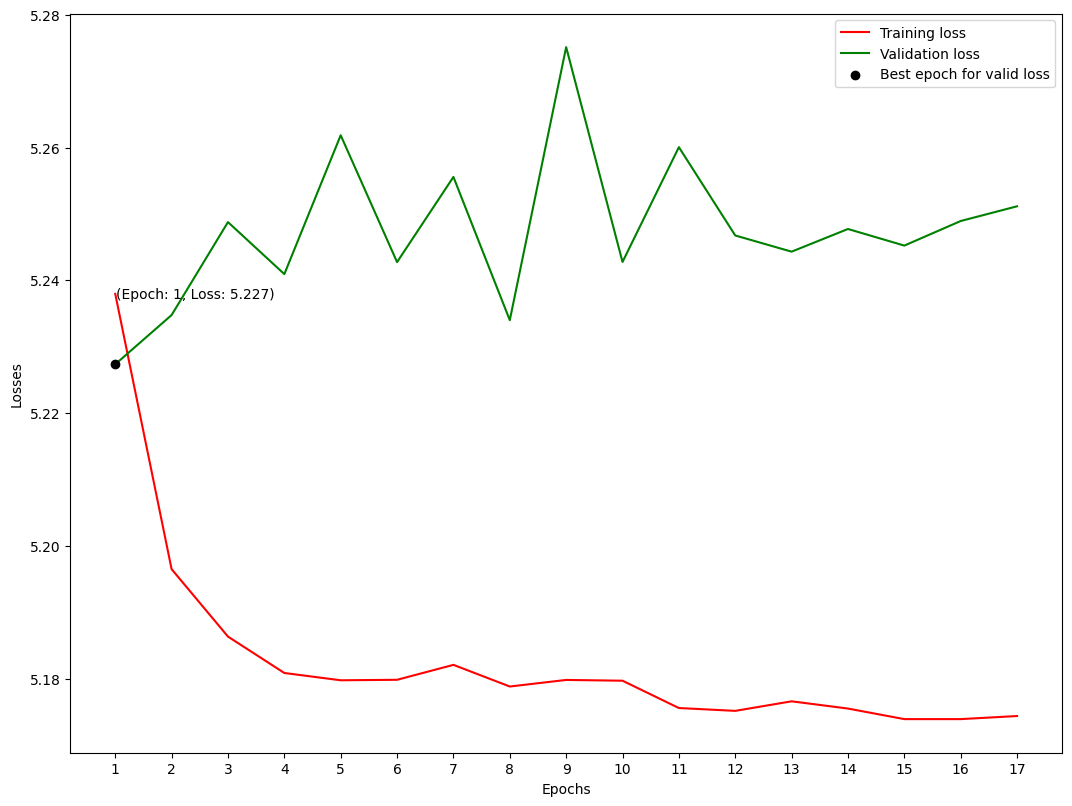

In [ ]:
# Plot

Test - Batch:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(190, 190)
F1 score: 0.0002752048986471959
Accuracy: 0.011799410029498525
Precision: 0.0001392260770442304
Recall: 0.011799410029498525


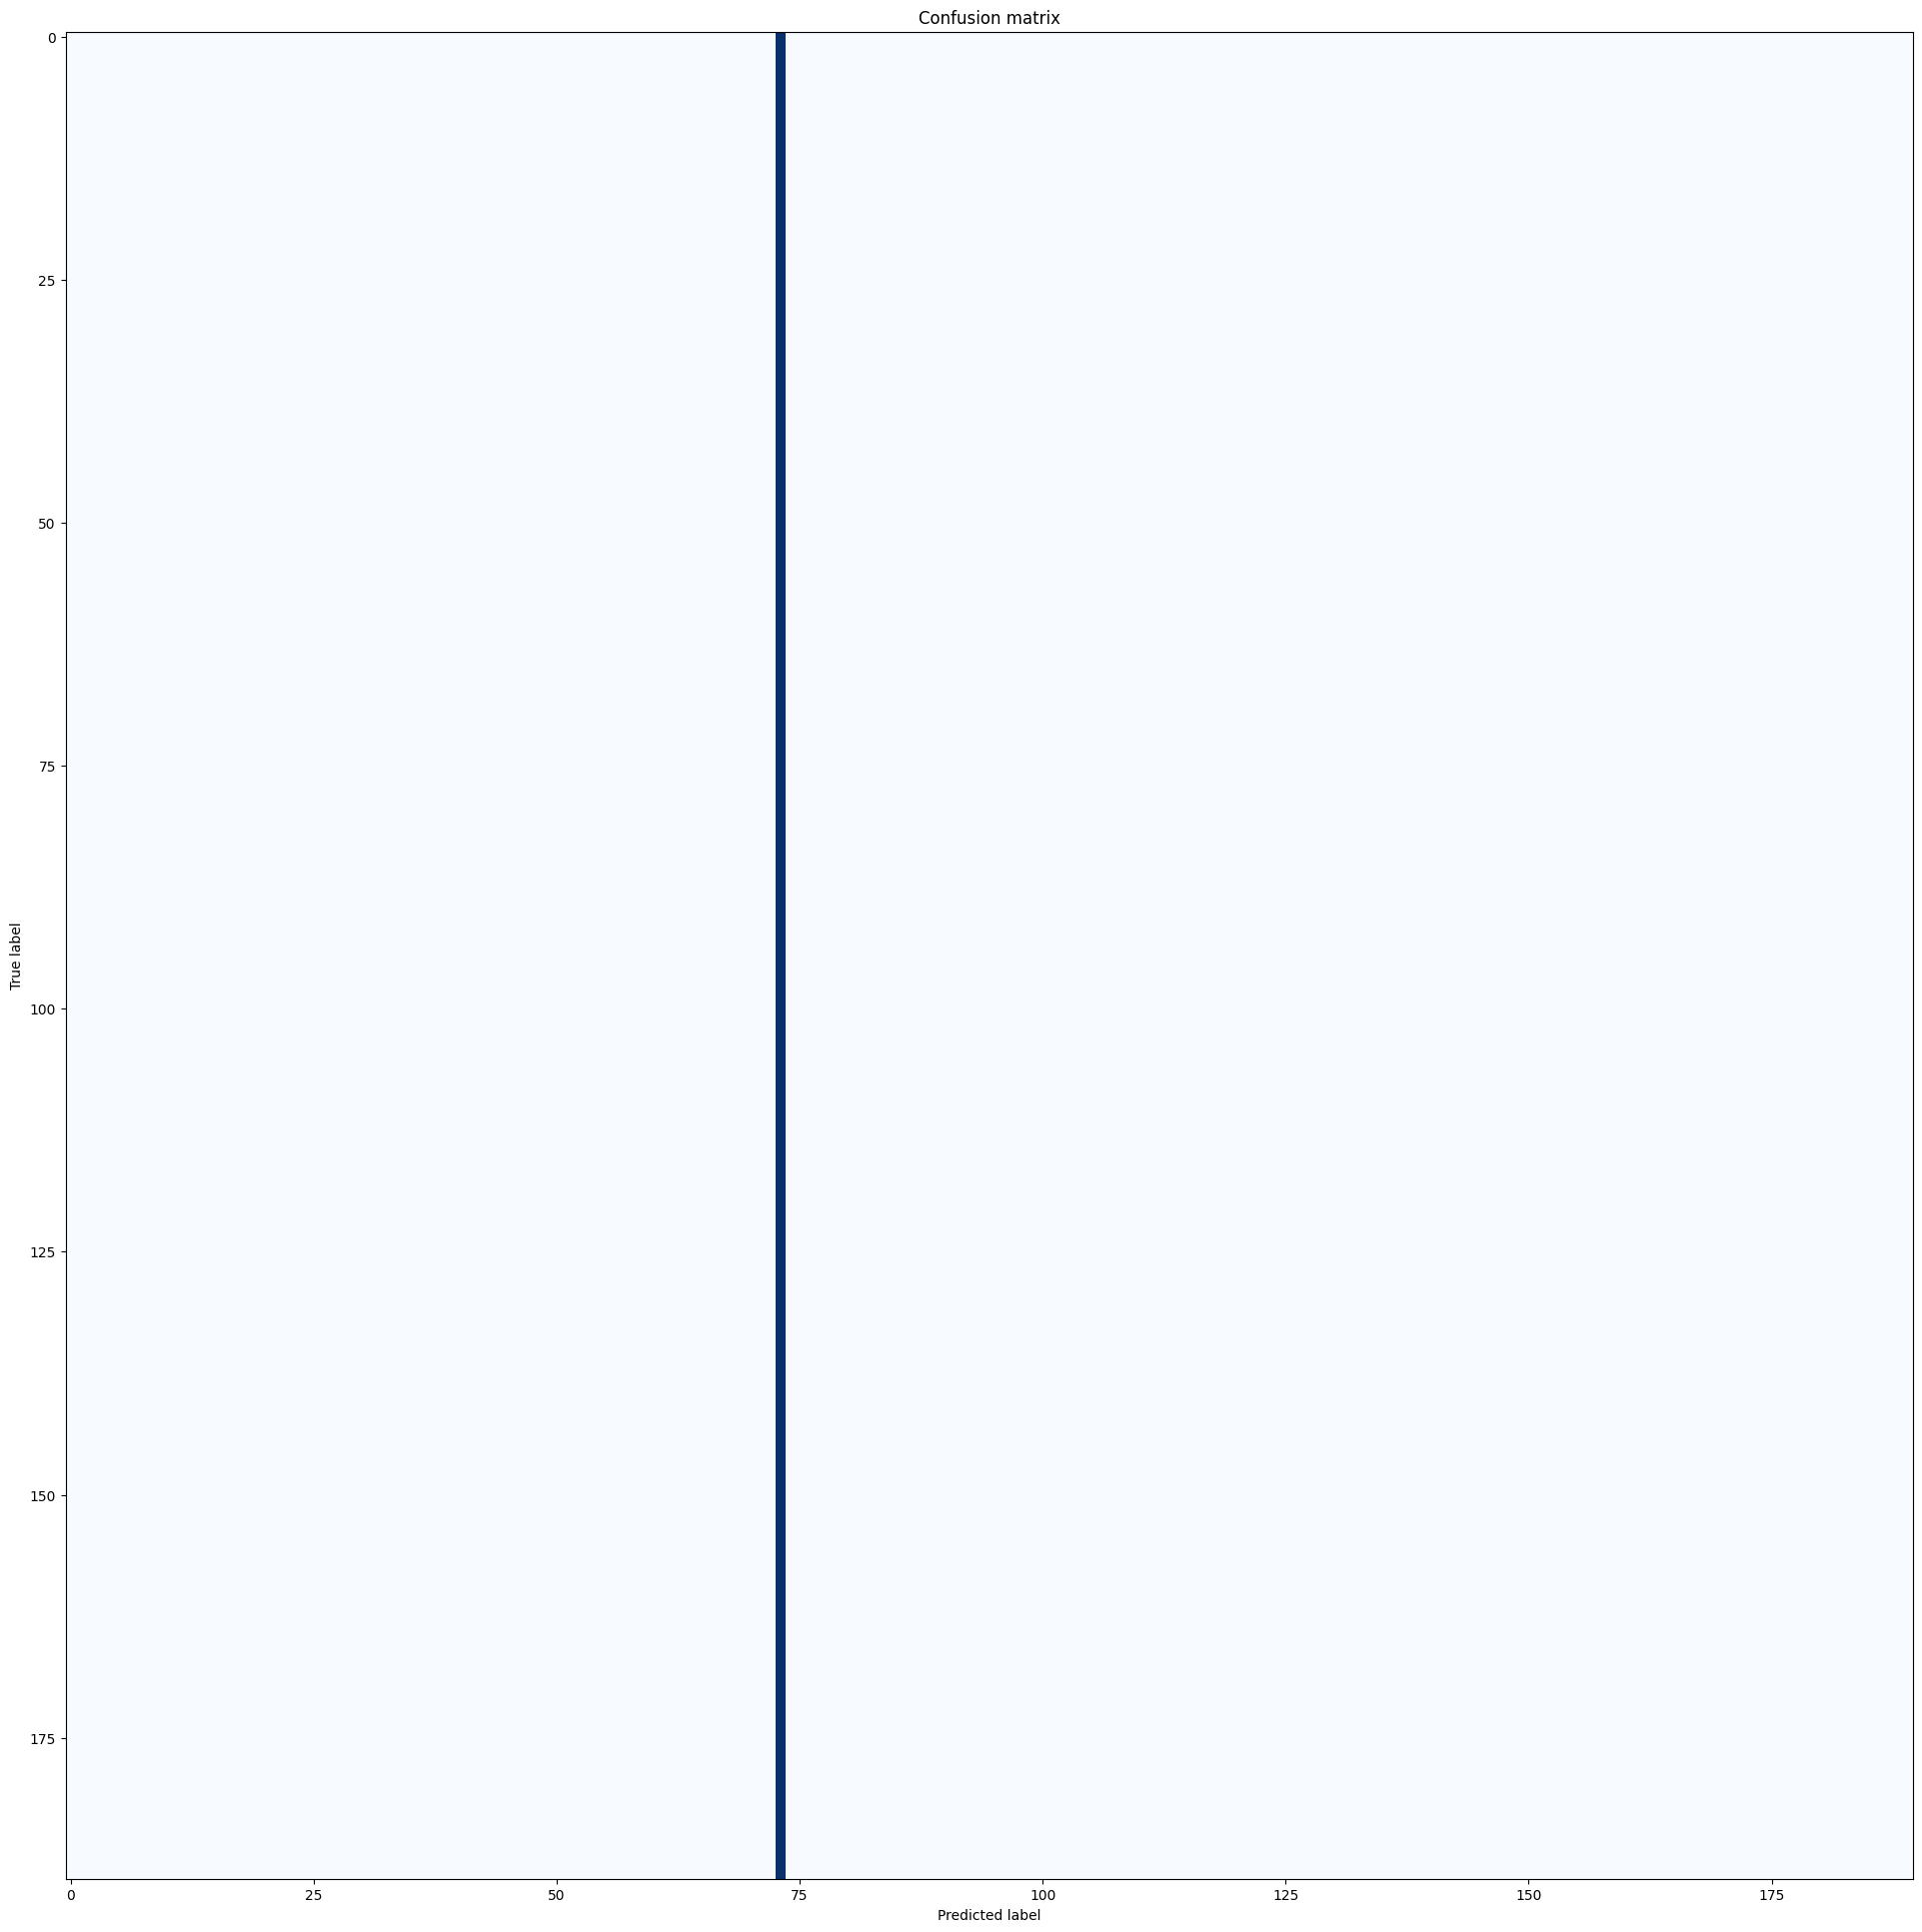

In [ ]:
# Confusion Matrix and results

LEARNING_RATE = 5e-5  \
WEIGHT_DECAY = 0.001 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
VERB_FRAME_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.4 \
NUM_LABEL_OCCURENCIES = 4 \
WEIGHTS_TYPE = no weights \
TRANSFORMER = bert-base-uncased \




The lowest loss is at the epoch 6


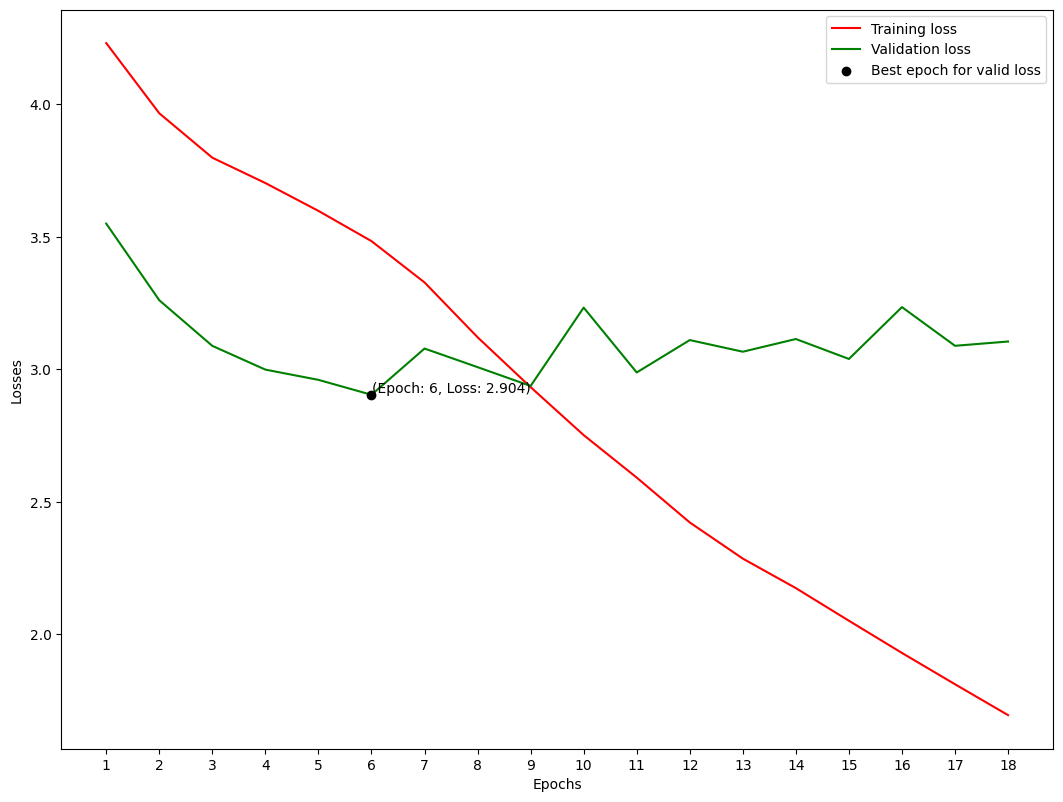

In [ ]:
# Plot

Test - Batch:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(190, 190)
F1 score: 0.3208593520540423
Accuracy: 0.36283185840707965
Precision: 0.3159666619843611
Recall: 0.36283185840707965


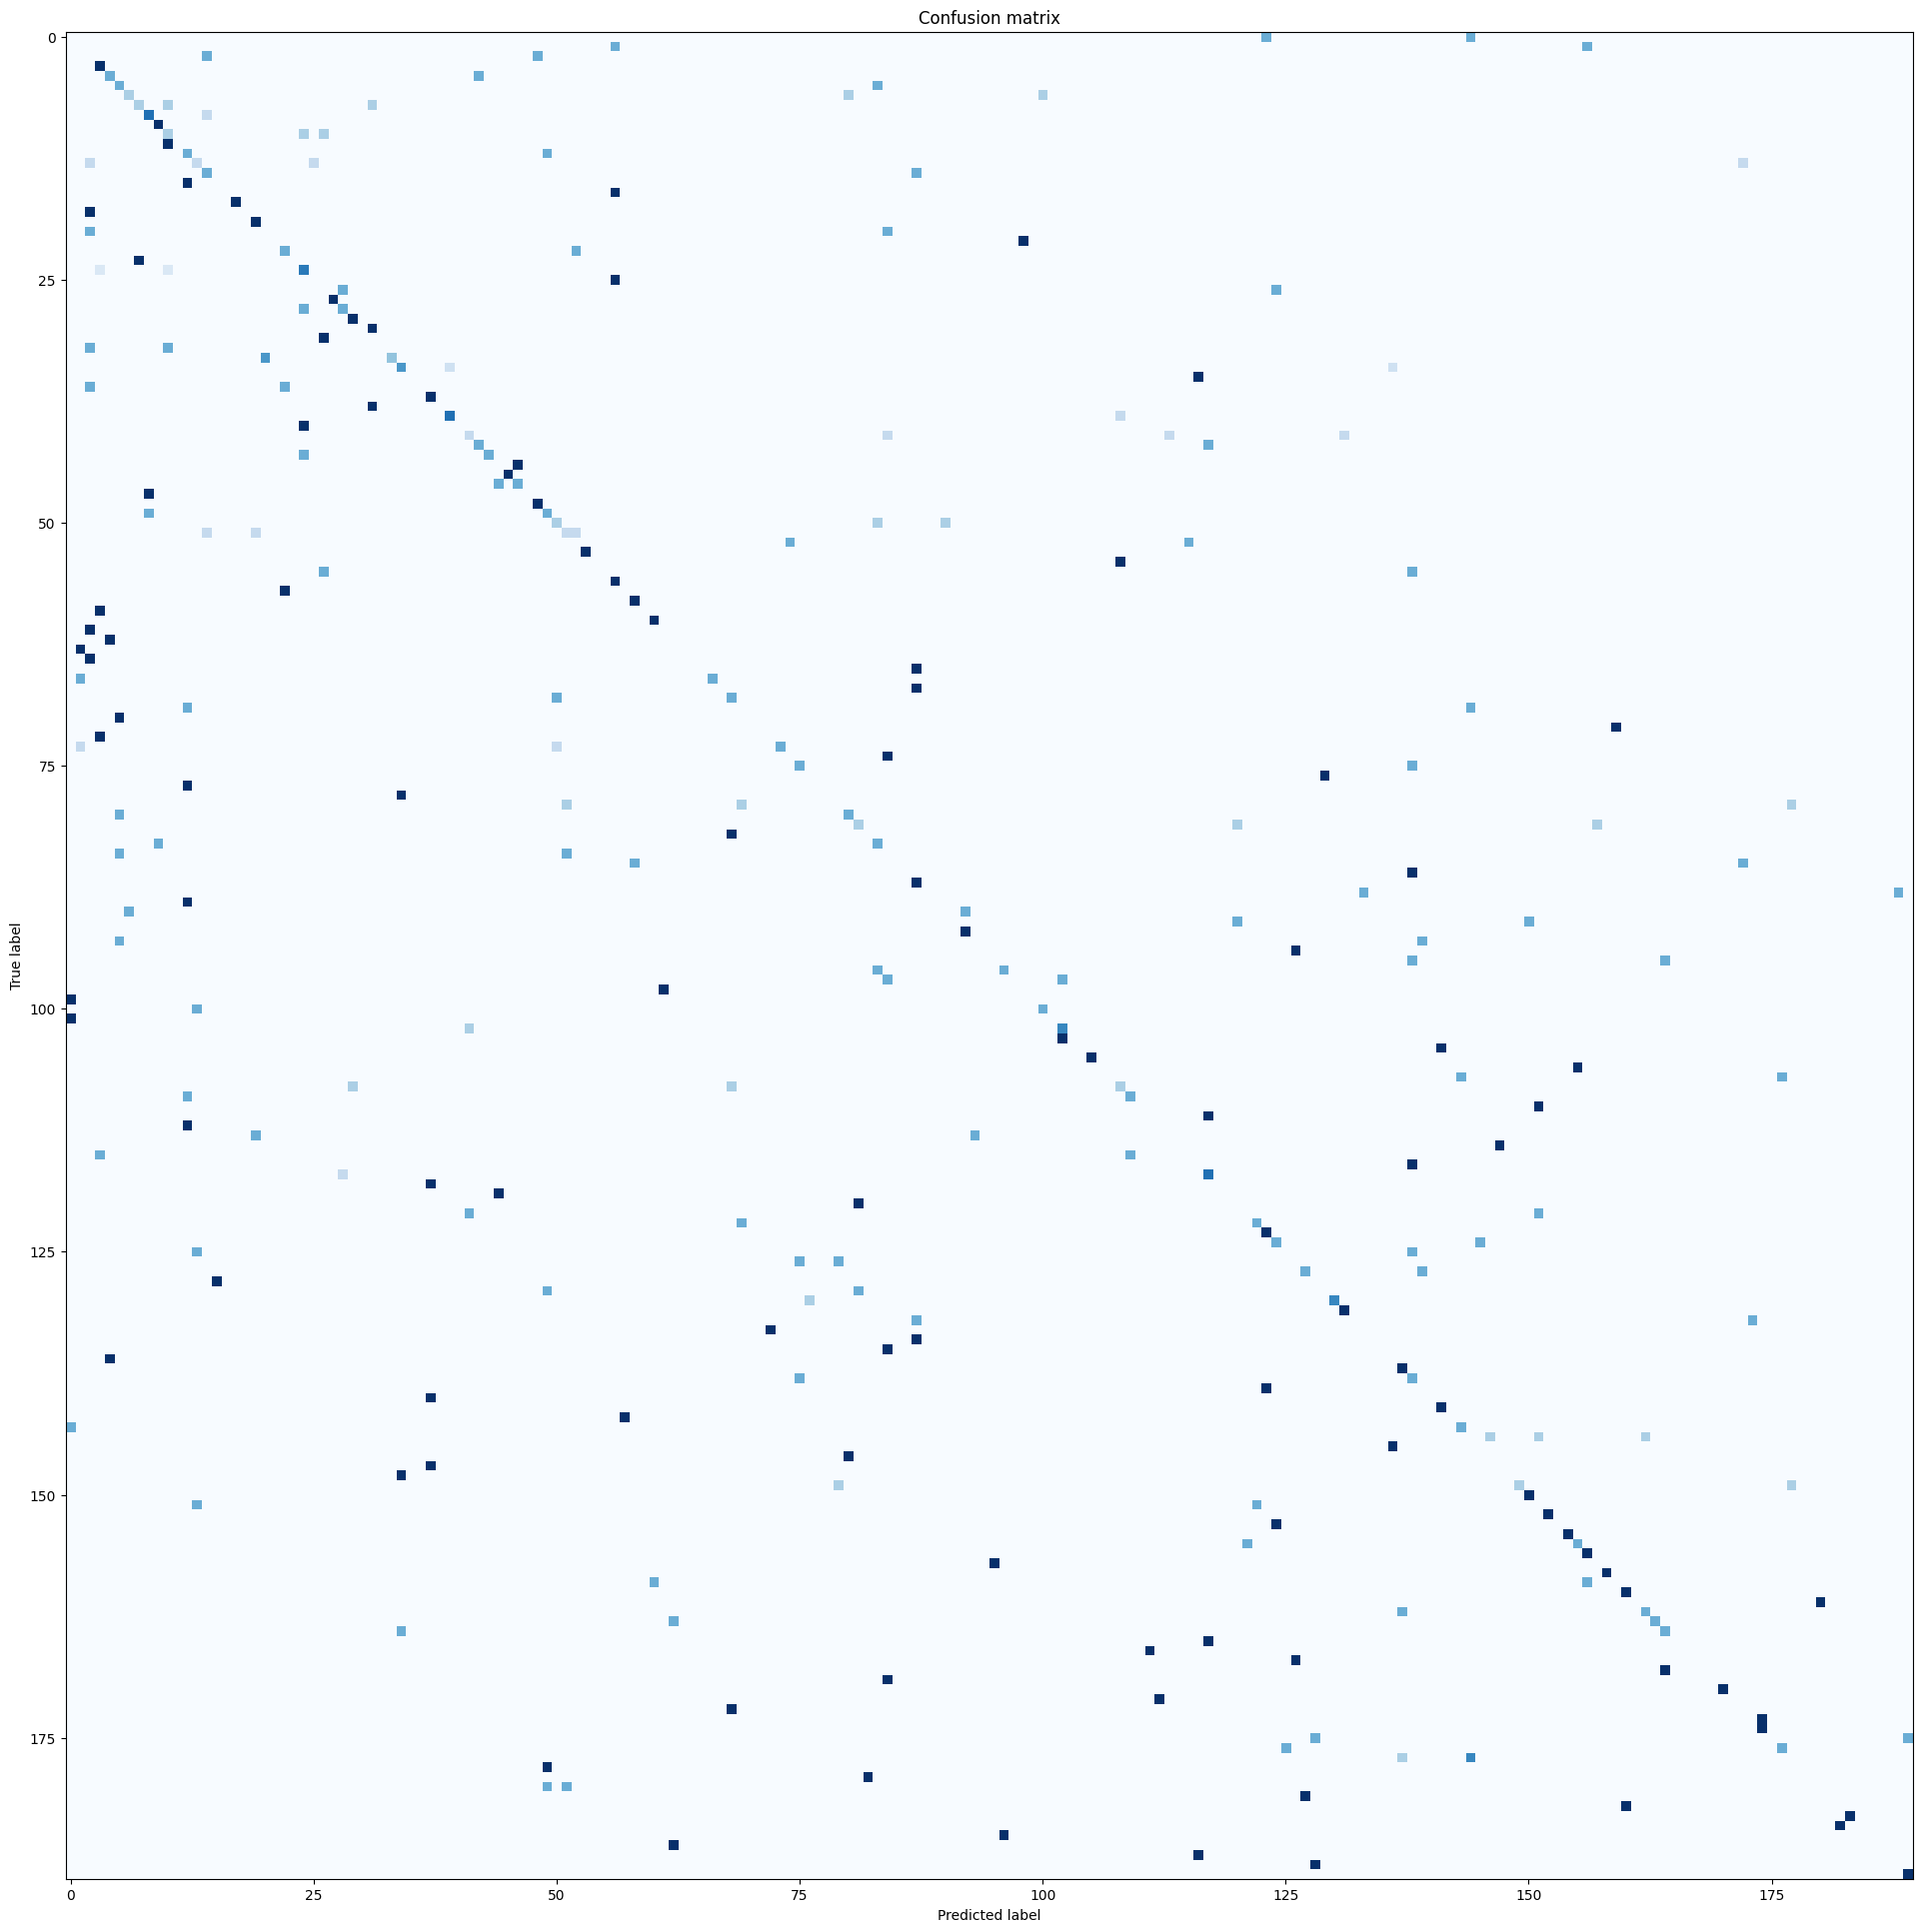

In [ ]:
# Confusion Matrix and results

LEARNING_RATE = 5e-5  \
WEIGHT_DECAY = 0.001 \
TRANSFORMER_LEARNING_RATE = 5e-5 \
TRANSFORMER_WEIGHT_DECAY = 0.0 \
BATCH_SIZE = 16 \
EPOCHS = 100 \
HIDDEN_DIM_LSTM = 200 \
POS_EMBEDDING_DIM = 128 \
VERB_FRAME_DIM = 128 \
BIDIRECTIONAL = True \
NUM_LAYER_LSTM = 2 \
DROPOUT = 0.2 \
DROPOUT_LSTM = 0.4 \
NUM_LABEL_OCCURENCIES = 4 \
WEIGHTS_TYPE = Gaussian \
TRANSFORMER = bert-base-uncased \




The lowest loss is at the epoch 7


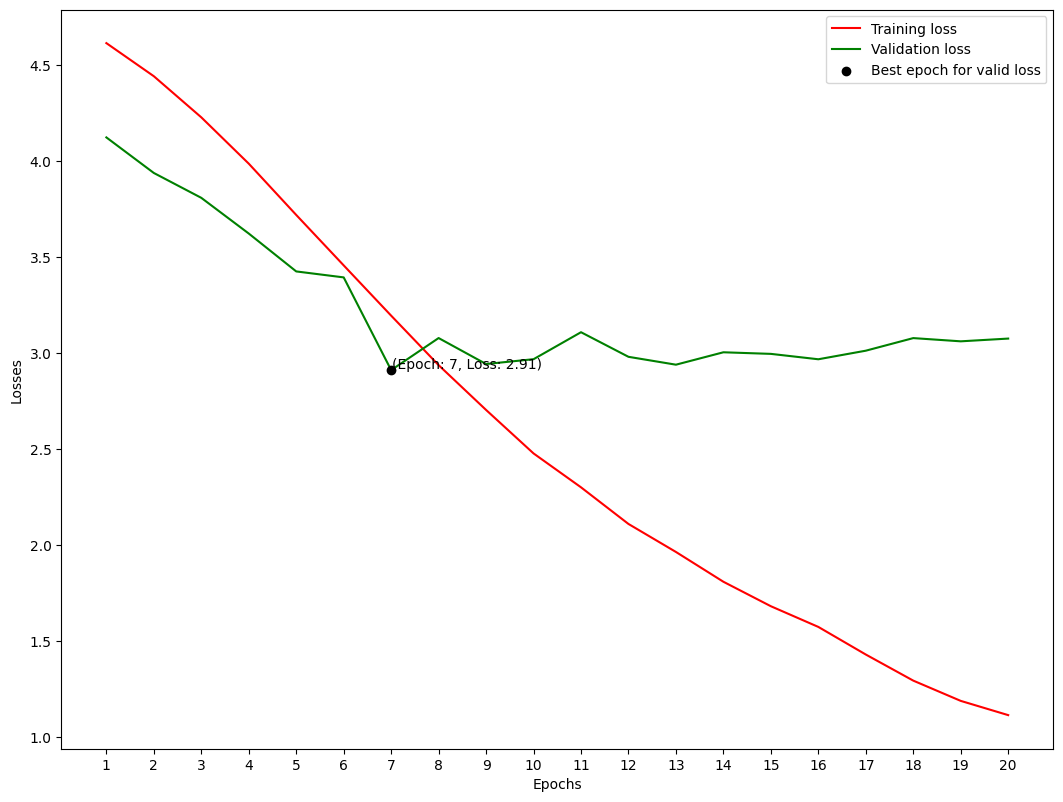

In [ ]:
# Plot

Test - Batch:   0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(190, 190)
F1 score: 0.3195741328484691
Accuracy: 0.35398230088495575
Precision: 0.32325467059980334
Recall: 0.35398230088495575


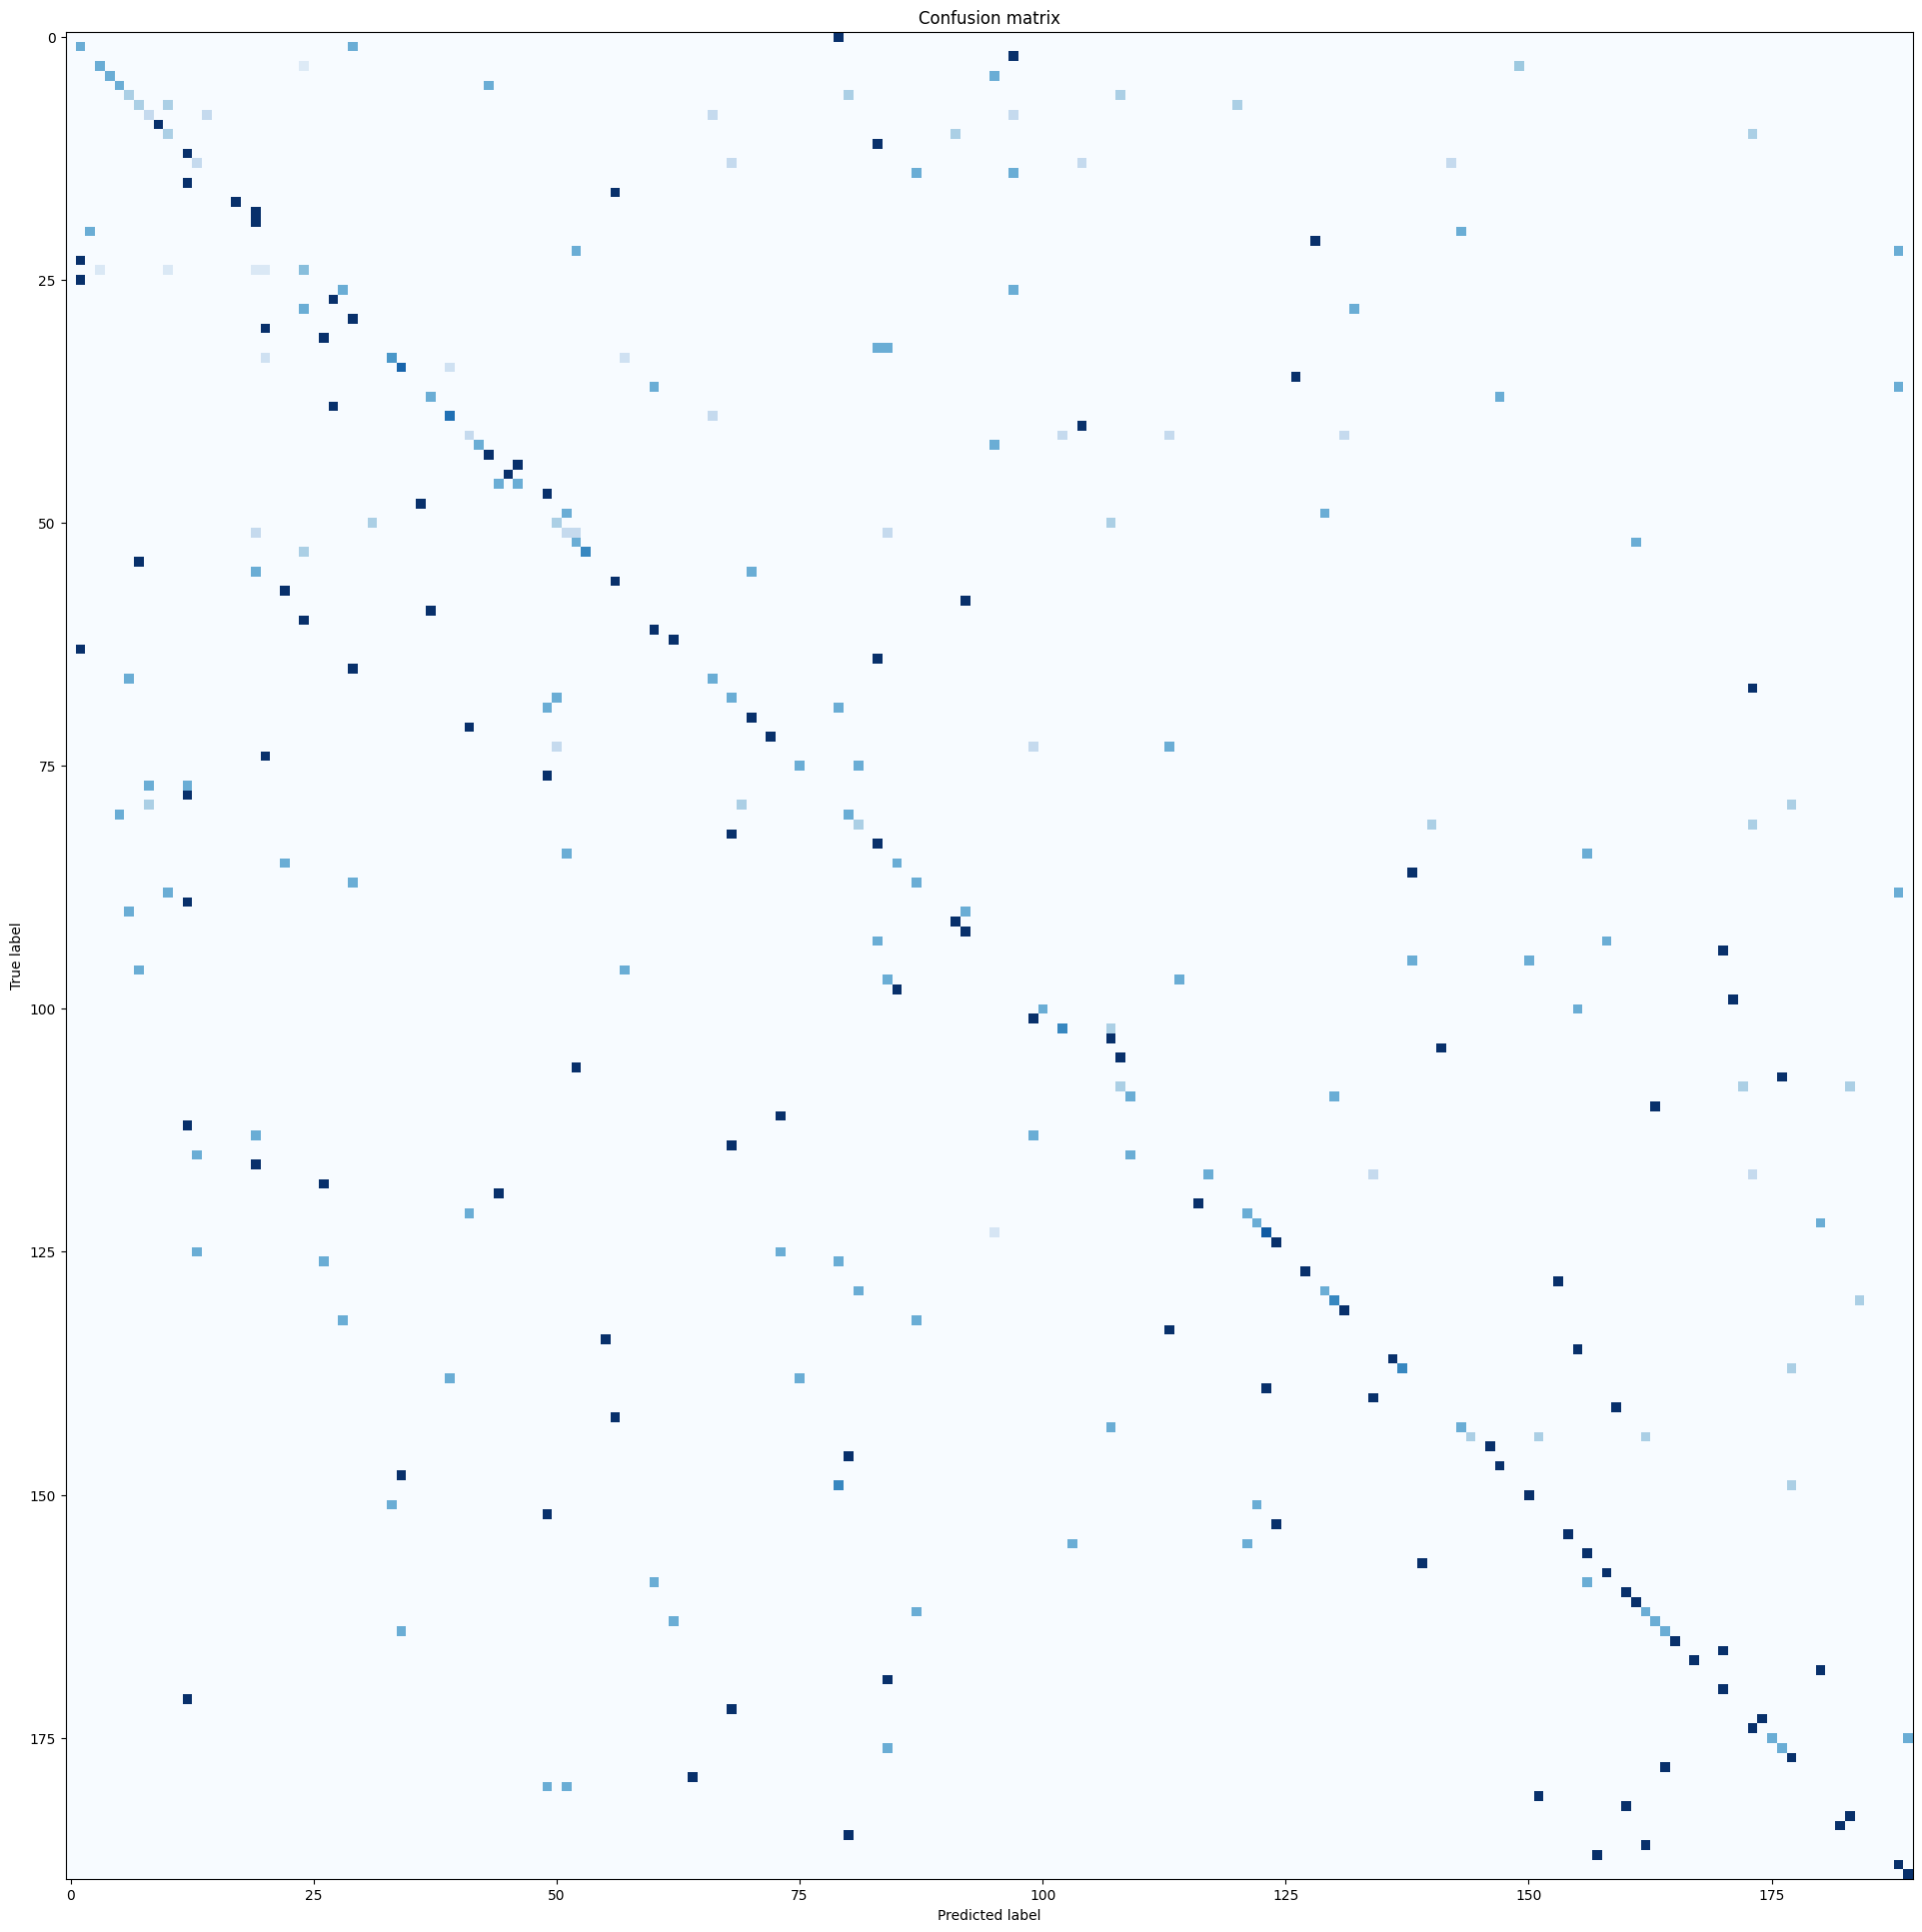

In [ ]:
# Confusion Matrix and results